<a href="https://colab.research.google.com/github/kashpk/pragya-kashyap/blob/main/Copy_of_Biomarker_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import copy
import plotly.express as px
import plotly.io as pio

#Pre-Processing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

#models
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern,ExpSineSquared,RationalQuadratic, ConstantKernel as C

#Scipy
from scipy.spatial import distance
import scipy
import scipy.optimize as opt
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.optimize import minimize
from scipy.stats import norm

#Pytorch
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim

#For plots
!pip install kaleido
!sudo apt-get install poppler-utils

#Optuna
!pip install optuna
import optuna


In [ ]:
!git clone https://github.com/ihdavjar/LCBM_analysis.git

**Data Preparation for the Lefse**

In [ ]:
data_1=pd.read_csv("/content/LCBM_analysis/feature-table.tsv")
data_1

In [ ]:
org_data=pd.read_csv("/content/LCBM_analysis/feature-table.tsv")

taxonomy_arr=list(org_data["taxonomy"])
otu_ids=list(org_data["otu_id"])
print(taxonomy_arr)
print(otu_ids)

#Removing the taxonomy and the otu_ids from the feature table
org_data=org_data.drop(["otu_id","taxonomy"],axis=1)


temp_data=np.array(org_data)
temp_otus=[]
for i in range(len(temp_data)):
  temp_otus.append("Otu"+str(i+1))


#Adding the labels to feature table
org_data=org_data.T
org_data.columns=temp_otus

print(org_data)
temp_data=pd.read_csv("/content/LCBM_analysis/label_data.csv")
temp_data=temp_data.drop(['Unnamed: 0'],axis=1)
temp_data_np=np.array(temp_data)

print(temp_data)

dict_temp={}
for i in range(len(temp_data_np)):
  if (temp_data_np[i,1]=="Squamous cell carcinoma"):
    dict_temp[temp_data_np[i,0]]="Squamous"
  else:
    dict_temp[temp_data_np[i,0]]=temp_data_np[i,1]

l_temp_row=list(org_data.index)
temp_labels=[]

for i in range(len(l_temp_row)):
  if (dict_temp[l_temp_row[i]]=="Adenosquamous carcinoma"):
    org_data.drop([l_temp_row[i]],axis=0,inplace=True)
  else:
    temp_labels.append(dict_temp[l_temp_row[i]])


org_data_np=np.array(org_data)
org_data

# org_data.insert(loc=0,column="label",value=0.03)
# org_data.insert(loc=1,column="Group",value=list(org_data.index))
# org_data.insert(loc=2,column="numOtus",value=3607)
org_data['treatment']=temp_labels


org_data.to_csv('complete_otus.csv',index=False)
# files.download('complete_otus.csv')
org_data


**Data Standardisation**

In [ ]:
le = preprocessing.LabelEncoder()

org_data_np=np.array(org_data)

labels=le.fit_transform(org_data_np[:,len(org_data_np[0])-1])

org_data_np[:,len(org_data_np[0])-1]=labels

stan_data=pd.DataFrame(org_data_np,columns=org_data.columns,index=org_data.index)
stan_data

In [ ]:
l_cols=taxonomy_arr
print(l_cols)
print(len(l_cols))
for i in range(len(l_cols)):
  temp=l_cols[i]
  temp=temp.split(";")
  print(temp)

**Phylum Wise Division**

In [ ]:
phyllum_labels=[]
count_no_phyllum=0

for i in range(len(l_cols)):
  temp=l_cols[i]
  temp=temp.split(";")
  if (len(temp)!=1):
    if (temp[1] not in phyllum_labels):
      phyllum_labels.append(temp[1])

for i in range(len(l_cols)):
  temp=l_cols[i]
  temp=temp.split(";")
  if (len(temp)==1):
    count_no_phyllum=count_no_phyllum+1

print("Number of Taxa without the phyllum labels:-",count_no_phyllum)

print("No. of distinct phyllum are:-",len(phyllum_labels))
print(phyllum_labels)

In [ ]:
temp_dict={}
for i in range(len(phyllum_labels)):
  temp_dict[phyllum_labels[i]]=0

temp_dict

In [ ]:
numpy_data=np.array(stan_data)
print(l_cols)
stan_data

In [ ]:
temps_arr=[]

for i in range(len(numpy_data)):
  temp_arr=numpy_data[i,0:len(numpy_data[0])-1].ravel()
  new_dict=copy.deepcopy(temp_dict)
  for j in range(len(temp_arr)):
    temp=l_cols[j]
    temp=temp.split(";")
    if (len(temp)!=1):
      new_dict[temp[1]]=new_dict[temp[1]]+temp_arr[j]
  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

phylum_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(stan_data.index))
phylum_data['treatment']=list(stan_data["treatment"])
print(temps_arr)

In [ ]:
phylum_data

**Lefse Data**

In [ ]:
data_1=pd.read_csv("/content/LCBM_analysis/phylum_data.csv")
data_1.dropna(inplace=True)
data_1.drop(["Unnamed: 0"],axis=1,inplace=True)
data_1

In [ ]:
data_np=np.array(data_1)
temp_labels=[]
for i in range(len(data_1)):
  if (data_np[i,1]<0):
    temp_labels.append("Adenocarcinoma")
  else:
    temp_labels.append("Squamous")

data_1["Class"]=temp_labels

temp_data.append(data_1)
data_1

In [ ]:
import plotly.express as px
# data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_1, x='scores', y='Names',orientation='h',color="Class",labels=dict(Names="", scores="LDA Score", Class="Groups"))

fig.show()

In [ ]:
data_1=pd.read_csv("/content/LCBM_analysis/phylum_data.csv",sep=",")
data_1.dropna(inplace=True)
data_1.drop(["Unnamed: 0"],axis=1,inplace=True)

data_1 = data_1[abs(data_1['scores'])>1]
data_1_np=np.array(data_1)
data_1

In [ ]:
chosen_phylum=data_1_np[:,0]


l = chosen_phylum
final_list = []
for i in l:
  final_list.append(i.strip())

chosen_phylum=final_list
print("Statistically significant phylum are:\n",chosen_phylum)

temp_phylums_names=[]
for i in range(len(chosen_phylum)):
  temp_phylums_names.append(" "+str(chosen_phylum[i]))

chosen_columns1=phylum_data.loc[:,temp_phylums_names]

chosen_columns1

**Genus Wise Division**

In [ ]:
genus_labels=[]
l_cols=taxonomy_arr

for i in range(len(l_cols)):
  temp=l_cols[i]
  temp=temp.split(";")
  if (len(temp)>5):
    if (temp[5] not in genus_labels):
      genus_labels.append(temp[5])

count_no_phyllum=0
for i in range(len(l_cols)):
  temp=l_cols[i]
  temp=temp.split(";")
  if (len(temp)==5):
    count_no_phyllum=count_no_phyllum+1

print("Number of Taxa without the Genus labels:-",count_no_phyllum)

print("No. of distinct Genus:-",len(genus_labels))
print(genus_labels)

In [ ]:
temp_dict={}
for i in range(len(genus_labels)):
  temp_dict[genus_labels[i]]=0

temp_dict

In [ ]:
numpy_data=np.array(stan_data)
print(l_cols)
stan_data

In [ ]:
temps_arr=[]
for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,0:len(numpy_data[0])-1].ravel()
  new_dict=copy.deepcopy(temp_dict)
  for j in range(len(temp_arr)):
    temp=l_cols[j]
    temp=temp.split(";")
    if (len(temp)>5):
      new_dict[temp[5]]=new_dict[temp[5]]+temp_arr[j]
  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)
genus_data=pd.DataFrame(temps_arr,columns=list(temp_dict.keys()),index=org_data.index)
genus_data['treatment']=list(stan_data["treatment"])
print(temps_arr)

In [ ]:
genus_data

**lefse data**

In [ ]:
data_1=pd.read_csv("/content/LCBM_analysis/genus_data.csv")
data_1.dropna(inplace=True)
data_1.drop(["Unnamed: 0"],axis=1,inplace=True)
data_1

In [ ]:
data_np=np.array(data_1)
temp_labels=[]
for i in range(len(data_1)):
  if (data_np[i,1]<0):
    temp_labels.append("Adenocarcinoma")
  else:
    temp_labels.append("Squamous")

data_1["Class"]=temp_labels

temp_data.append(data_1)

data_1

In [ ]:
import plotly.express as px
# data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_1, x='scores', y='Names',orientation='h',color="Class",labels=dict(Names="", scores="LDA Score", Class="Groups"))

fig.show()

In [ ]:
data_2=pd.read_csv("/content/LCBM_analysis/genus_data.csv",sep=",")
data_2.dropna(inplace=True)
data_2.drop(["Unnamed: 0"],axis=1,inplace=True)

data_2 = data_2[abs(data_2['scores'])>1]
data_2_np=np.array(data_2)
data_2

In [ ]:
chosen_genus=data_2_np[:,0]


l = chosen_genus
final_list = []
for i in l:
  final_list.append(i.strip())

chosen_genus=final_list
print("Statistically significant genus are:\n",chosen_genus)

temp_genus_names=[]
for i in range(len(chosen_genus)):
  if (str(chosen_genus[i])=='g__0319.6G20'):
    temp_genus_names.append(" g__0319-6G20")
  else:
    temp_genus_names.append(" "+str(chosen_genus[i]))

chosen_columns2=genus_data.loc[:,temp_genus_names]

chosen_columns2

**Collecting Useful Columns from the MetaData**

In [ ]:
meta_data=pd.read_csv("/content/LCBM_analysis/SraRunTable.tsv",sep='\t')
meta_data.drop([0],axis=0,inplace=True)
meta_data

**Choosing the important columns**

In [ ]:
print(meta_data.columns)

**Choosing env_material, Host_Age, host_sex, smoker**

In [ ]:
meta_data=meta_data[[" Sample-id","env_material","host_sex","Host_Age","smoker"]]
meta_data

In [ ]:
meta_data_np=np.array(meta_data)
print(meta_data_np)

temp_sample_dict={}

for i in range(len(meta_data_np)):
  temp_sample_dict[meta_data_np[i,0]]=meta_data_np[i,1:]

In [ ]:
temp_sample_dict

In [ ]:
temp_sample_names=list(phylum_data.index)

chosen_column3_np=[]

for i in range(len(temp_sample_names)):
  chosen_column3_np.append(temp_sample_dict[temp_sample_names[i]])

chosen_column3_np=np.array(chosen_column3_np)
chosen_column3_np

chosen_columns3=pd.DataFrame(chosen_column3_np,index=temp_sample_names,columns=list(meta_data.columns)[1:])
chosen_columns3

**Removing Instances with missing Data**

In [ ]:
meta_data.dropna(inplace=True)
meta_data

**Data Preprocessing**

In [ ]:
chosen_column1_np=np.array(chosen_columns1)
chosen_column2_np=np.array(chosen_columns2)
chosen_column3_np=np.array(chosen_columns3)

data=np.array(stan_data)

x_data=np.c_[chosen_column1_np,chosen_column2_np,chosen_column3_np]
print(np.shape(x_data))

y_data=np.array(stan_data["treatment"]).astype(int)

result_data=pd.DataFrame(x_data,index=phylum_data.index,columns=list(chosen_columns1.columns)+list(chosen_columns2.columns)+list(chosen_columns3.columns))
result_data["label"]=y_data


In [ ]:
# result_data.to_csv("data_dnn.csv")
# files.download("data_dnn.csv")

**label encoding**

In [ ]:
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le3 = preprocessing.LabelEncoder()

result_data["env_material"]=le1.fit_transform(result_data["env_material"])
result_data["host_sex"]=le2.fit_transform(result_data["host_sex"])
result_data["smoker"]=le3.fit_transform(result_data["smoker"])

# result_data.drop(['env_material','Host_Age','host_sex'],axis=1,inplace=True)
result_data

In [ ]:
def bray_curtis_array(l1,l2):
  bc=distance.braycurtis(l1,l2)
  return bc


def bray_curtis_comp(data):
  d_mat=[]

  for i in range(len(data)):
    d_mat1=[]
    for j in range(len(data)):
      temp_1=data[i,:len(data[0])-1]
      temp_2=data[j,:len(data[0])-1]
      d_mat1.append(bray_curtis_array(temp_1,temp_2))
    d_mat.append(d_mat1)
  d_mat=np.array(d_mat)
  return d_mat

result_data_out_np=np.array(result_data_no_out)
bray_curtis_data=pd.DataFrame(bray_curtis_comp(result_data_out_np))


In [ ]:
bray_curtis_data_np=np.array(bray_curtis_data)

X = bray_curtis_data_np
pca = PCA(n_components=4)
pca.fit(X)

print(pca.explained_variance_ratio_)

x_new=pca.transform(X)

x=x_new[:,0]
y=x_new[:,1]
z=x_new[:,2]
z1=x_new[:,3]

In [ ]:
fig = px.scatter(x=x, y=y,color=org_data['label'])
fig.show()

In [ ]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots
# df = px.data.iris()
fig = px.scatter_3d(x=x, y=y, z=z,
              color=org_data['label'])



# pio.write_image(fig, 'image.png',scale=7, width=1080, height=1080)
# files.download('image.png')

fig.show()

**Model Building**

In [ ]:
result_data_no_out = copy.deepcopy(result_data)
x_data_pd=result_data_no_out.drop(['label'],axis=1)

#Normalisation
scaler = preprocessing.MinMaxScaler()

x_data_pd_stan=pd.DataFrame(scaler.fit_transform(x_data_pd),columns=x_data_pd.columns,index=x_data_pd.index)

x_data_pd_stan= x_data_pd

x_data_pd_stan["sample_id"] = result_data.index

x_data_pd['label']=result_data['label']

x_data_pd_stan['label']=result_data['label']


result_data=x_data_pd_stan


result_data_class0=result_data[result_data["label"]==0]
result_data_class1=result_data[result_data["label"]==1]

result_data_class_0_np=np.array(result_data_class0)
result_data_class_1_np=np.array(result_data_class1)

print(np.unique(result_data_class_0_np[:,len(result_data_class_0_np[0])-1]))
print(np.unique(result_data_class_1_np[:,len(result_data_class_1_np[0])-1]))

x_class_0=result_data_class_0_np[:,0:len(result_data_class_0_np[0])-1]
y_class_0=result_data_class_0_np[:,len(result_data_class_0_np[0])-1].astype(int)

x_class_1=result_data_class_1_np[:,0:len(result_data_class_1_np[0])-1]
y_class_1=result_data_class_1_np[:,len(result_data_class_1_np[0])-1].astype(int)

#CLASS 0
x_train_0, x_temp_0, y_train_0, y_temp_0 = train_test_split(x_class_0, y_class_0, test_size=0.3,shuffle=True, random_state=42)
x_val_0, x_test_0, y_val_0, y_test_0 = train_test_split(x_temp_0, y_temp_0, test_size=0.5,shuffle=True, random_state=42)

#CLASS 1
x_train_1, x_temp_1, y_train_1, y_temp_1 = train_test_split(x_class_1, y_class_1, test_size=0.3,shuffle=True, random_state=42)
x_val_1, x_test_1, y_val_1, y_test_1 = train_test_split(x_temp_1, y_temp_1, test_size=0.5,shuffle=True, random_state=42)

#Train Data
x_train=np.r_[x_train_0,x_train_1]
y_train=np.r_[y_train_0,y_train_1]

sample_id_train = x_train[:,len(x_train[0])-1]

x_train = x_train[:,:len(x_train[0])-1].astype(float)


#Val Data
x_val=np.r_[x_val_0,x_val_1]
y_val=np.r_[y_val_0,y_val_1]

sample_id_val = x_val[:,len(x_val[0])-1]

x_val = x_val[:,:len(x_val[0])-1].astype(float)

#Test Data
x_test=np.r_[x_test_0,x_test_1]
y_test=np.r_[y_test_0,y_test_1]

sample_id_test = x_test[:,len(x_test[0])-1]

x_test = x_test[:,:len(x_test[0])-1].astype(float)


print("Number of Instances in Training Data of class 0:-",len(x_train_0))
print("Number of Instances in Training Data of class 1:-",len(x_train_1))

print("Number of Instances in Validation Data of class 0:-",len(x_val_0))
print("Number of Instances in Validation Data of class 1:-",len(x_val_1))

print("Number of Instances in Testing Data of class 0:-",len(x_test_0))
print("Number of Instances in Testing Data of class 1:-",len(x_test_1))



#Test Full Data
x_test_1=np.r_[x_temp_0,x_temp_1]
y_test_1=np.r_[y_temp_0,y_temp_1]

sample_id_test_1 = x_test_1[:,len(x_test_1[0])-1]

x_test_1 = x_test_1[:,:len(x_test_1[0])-1].astype(float)

print("Number of Instance in Testing Data 1 of class 0:-",len(x_temp_0))
print("Number of Instance in Testing Data 1 of class 1:-",len(x_temp_1))


**Downloading The Data**

In [ ]:
l_cols_stan = list(x_data_pd_stan.columns)

l_cols_stan = l_cols_stan[0:len(l_cols_stan)-1]

x_train_pd = pd.DataFrame(x_train,columns=l_cols_stan[:len(l_cols_stan)-1])

x_train_pd["label"] = y_train

x_train_pd.to_csv("Training_data.csv")

x_test_pd = pd.DataFrame(x_test_1,columns=l_cols_stan[:len(l_cols_stan)-1])

x_test_pd["label"] = y_test_1

x_test_pd.to_csv("Testing_data.csv")

**Model Training**

**Logistic Regression**

In [ ]:
model_lr = LogisticRegression(random_state=0,max_iter=1000).fit(x_train,y_train)
y_pred_lr=model_lr.predict(x_test)

print("Training Accuracy is:-",model_lr.score(x_train,y_train))
print("Classification Accuracy is:-",model_lr.score(x_test,y_test))

In [ ]:
temp_arr=model_lr.coef_
print(temp_arr)
temp_arr.sort()
temp_arr

In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

In [ ]:
dat_lr=confusion_matrix(y_pred_lr,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
probs = model_lr.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Gaussian Naive Bayes**

In [ ]:
model_nb = GaussianNB().fit(x_train,y_train)
y_pred_nb=model_nb.predict(x_test)

print("Training Accuracy is:-",model_nb.score(x_train,y_train))
print("Classification Accuracy is:-",model_nb.score(x_test,y_test))

In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_nb, target_names=target_names))

In [ ]:
dat_lr=confusion_matrix(y_pred_nb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
probs = model_nb.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Decision Tree Classifier**

In [ ]:
acc=[]
for i in range(20):
  model = DecisionTreeClassifier(max_depth=i+1).fit(x_train,y_train)
  acc.append(model.score(x_val,y_val))

plt.plot(acc)
plt.show()
best_depth=np.argmax(acc)+1
print(best_depth)

In [ ]:
model_dc = DecisionTreeClassifier(max_depth=best_depth).fit(x_train,y_train)
y_pred_dc=model_dc.predict(x_test)

print("Training Accuracy is:-",model_dc.score(x_train,y_train))
print("Classification Accuracy is:-",model_dc.score(x_test,y_test))

In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_dc, target_names=target_names))

In [ ]:
dat_lr=confusion_matrix(y_pred_dc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
probs = model_dc.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Random Forest Classifier**

In [ ]:
acc=[]
for i in range(20):
  model = RandomForestClassifier(max_depth=i+1,n_estimators=1000).fit(x_train,y_train)
  acc.append(model.score(x_val,y_val))

plt.plot(acc)
plt.show()
best_depth=np.argmax(acc)+1
print(best_depth)

In [ ]:
model_rfc = RandomForestClassifier(max_depth=best_depth,n_estimators=1000,random_state=0).fit(x_train,y_train)
y_pred_rfc=model_rfc.predict(x_test)


print("Training Accuracy is:-",model_rfc.score(x_train,y_train))
print("Classification Accuracy is:-",model_rfc.score(x_test,y_test))

In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_rfc, target_names=target_names))

In [ ]:
dat_lr=confusion_matrix(y_pred_rfc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
probs = model_rfc.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**XGBoost Classifier**

In [ ]:
acc=[]
for i in range(10):
  model = XGBClassifier(max_depth=i+1).fit(x_train,y_train)
  acc.append(model.score(x_val,y_val))

plt.plot(acc)
plt.show()
best_depth=np.argmax(acc)+1
print(best_depth)

In [ ]:
model_xgb = XGBClassifier(max_depth=best_depth,random_state=0).fit(x_train,y_train)
y_pred_xgb=model_xgb.predict(x_test)

print("Training Accuracy is:-",model_xgb.score(x_train,y_train))
print("Classification Accuracy is:-",model_xgb.score(x_test,y_test))

Training Accuracy is:- 0.8092783505154639
Classification Accuracy is:- 0.5581395348837209


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.55      0.73      0.63        22
      Squamous       0.57      0.38      0.46        21

      accuracy                           0.56        43
     macro avg       0.56      0.55      0.54        43
  weighted avg       0.56      0.56      0.54        43



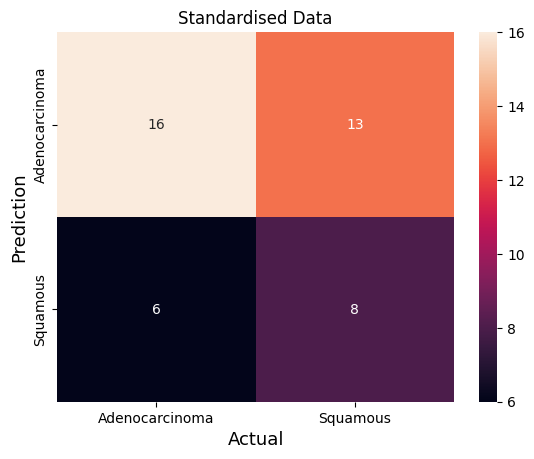

In [ ]:
dat_lr=confusion_matrix(y_pred_xgb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

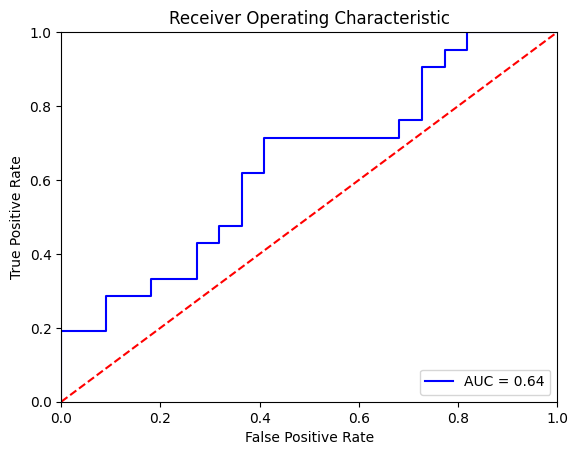

In [ ]:
probs = model_xgb.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Gaussian Process Classifier**

In [ ]:
lbound = 1e-5
rbound = 1e5

n_restarts = 50

n_features = len(x_train[0])

kernel=C(1.0, (lbound,rbound)) * RBF(n_features*[n_features], (lbound,rbound))  + WhiteKernel()

model_gpc = GaussianProcessClassifier().fit(x_train,y_train)
y_pred_gpc=model_gpc.predict(x_test)

print("Classification Accuracy is:-",model_gpc.score(x_test,y_test))

Classification Accuracy is:- 0.46511627906976744


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_gpc, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.49      0.77      0.60        22
      Squamous       0.38      0.14      0.21        21

      accuracy                           0.47        43
     macro avg       0.43      0.46      0.40        43
  weighted avg       0.43      0.47      0.41        43



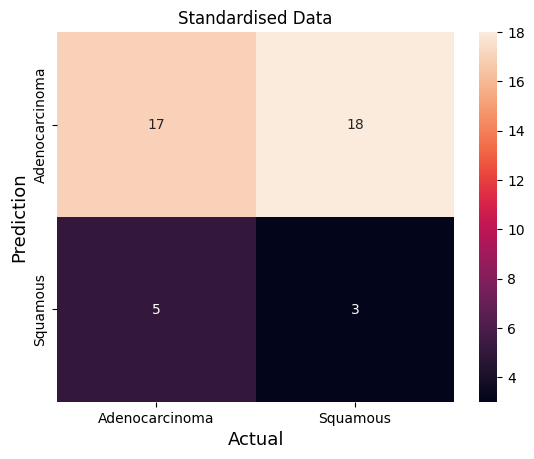

In [ ]:
dat_lr=confusion_matrix(y_pred_gpc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

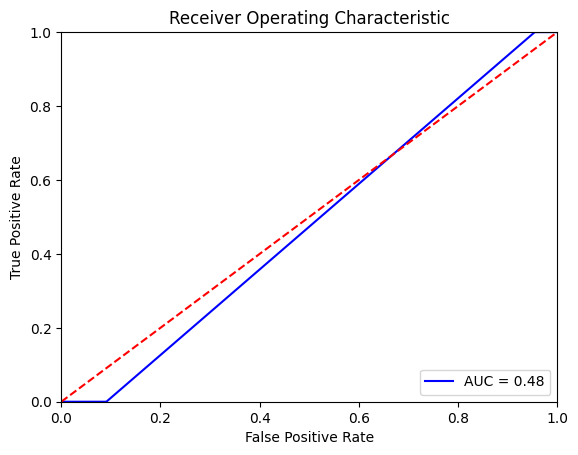

In [ ]:
probs = model_gpc.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**KNN Classifier**

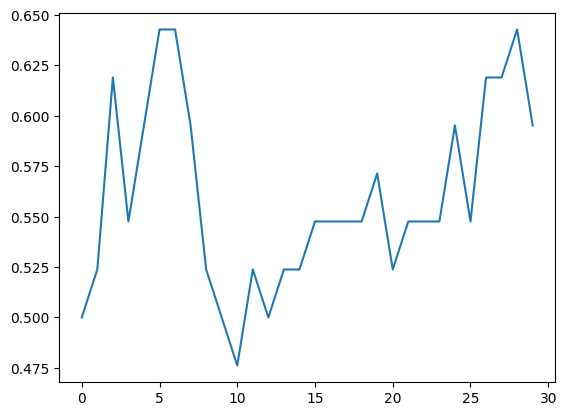

6


In [ ]:
acc=[]
for i in range(30):
  model = KNeighborsClassifier(n_neighbors=i+1).fit(x_train,y_train)
  acc.append(model.score(x_val,y_val))

plt.plot(acc)
plt.show()
best_n=np.argmax(acc)+1
print(best_n)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=best_n).fit(x_train,y_train)
y_pred_knn=model_knn.predict(x_test)

print("Classification Accuracy is:-",model_knn.score(x_test,y_test))

Classification Accuracy is:- 0.3953488372093023


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_knn, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.44      0.68      0.54        22
      Squamous       0.22      0.10      0.13        21

      accuracy                           0.40        43
     macro avg       0.33      0.39      0.33        43
  weighted avg       0.33      0.40      0.34        43



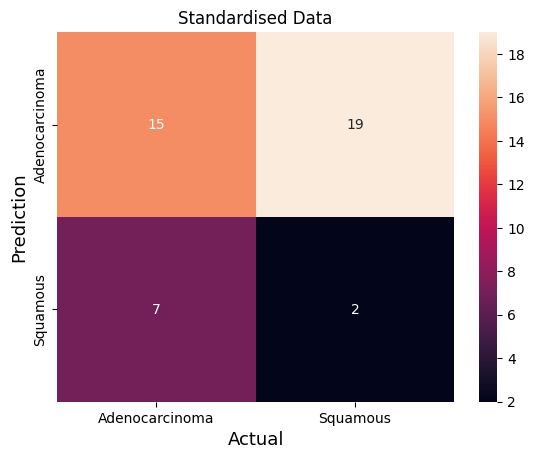

In [ ]:
dat_lr=confusion_matrix(y_pred_knn,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

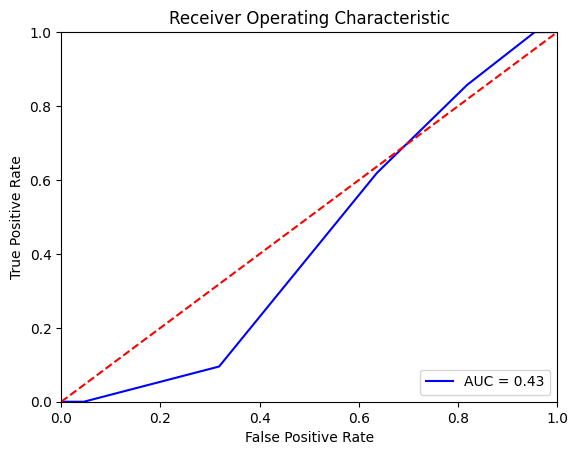

In [ ]:
probs = model_knn.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Neural Network Classifier**

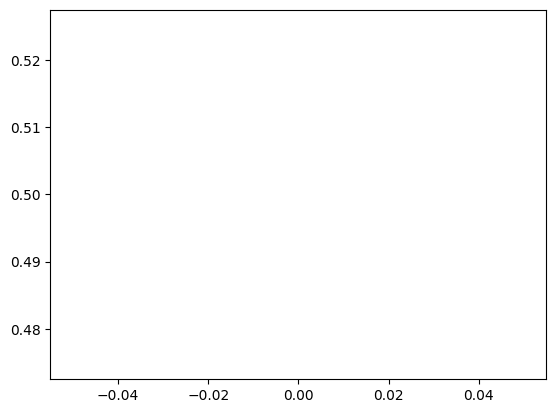

In [ ]:
#For the Standardised data
acc1=[]
for i in range(1):
  model = MLPClassifier(random_state=1,hidden_layer_sizes=[i+1], max_iter=3000)
  model.fit(x_train,y_train.ravel())
  acc1.append(model.score(x_val,y_val.ravel()))

plt.plot(acc1)
plt.show()

best_hidden1=np.argmax(acc1)+1

In [ ]:
model_nn = MLPClassifier(random_state=1,hidden_layer_sizes=[best_hidden1], max_iter=3000).fit(x_train,y_train)
y_pred_nn=model_nn.predict(x_test)

print(best_hidden1)

print("Accuracy on the training data is:-",model_nn.score(x_train,y_train))
print("Classification Accuracy is:-",model_nn.score(x_test,y_test))

1
Accuracy on the training data is:- 0.5154639175257731
Classification Accuracy is:- 0.4883720930232558


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_nn, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.50      0.95      0.66        22
      Squamous       0.00      0.00      0.00        21

      accuracy                           0.49        43
     macro avg       0.25      0.48      0.33        43
  weighted avg       0.26      0.49      0.34        43



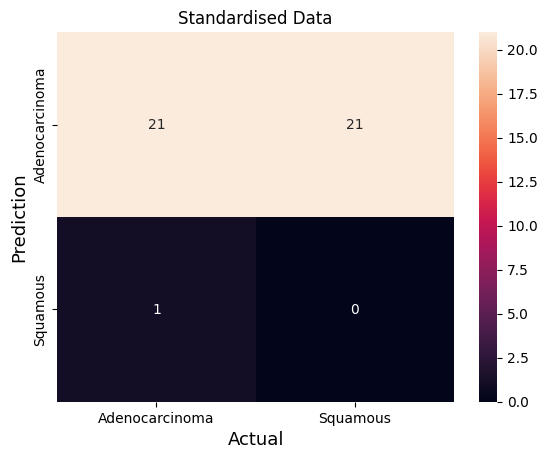

In [ ]:
dat_lr=confusion_matrix(y_pred_nn,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

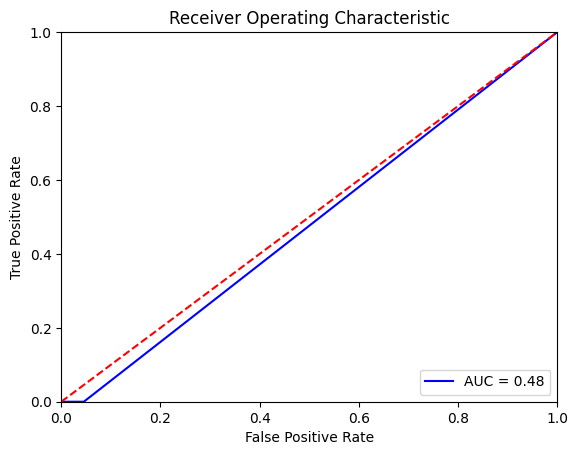

In [ ]:
probs = model_nn.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**LDA Classifier**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_lda =LinearDiscriminantAnalysis().fit(x_train,y_train)
y_pred_lda=model_lda.predict(x_test)

print("Classification Accuracy is:-",model_lda.score(x_test,y_test))

Classification Accuracy is:- 0.6046511627906976


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_lda, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.57      0.91      0.70        22
      Squamous       0.75      0.29      0.41        21

      accuracy                           0.60        43
     macro avg       0.66      0.60      0.56        43
  weighted avg       0.66      0.60      0.56        43



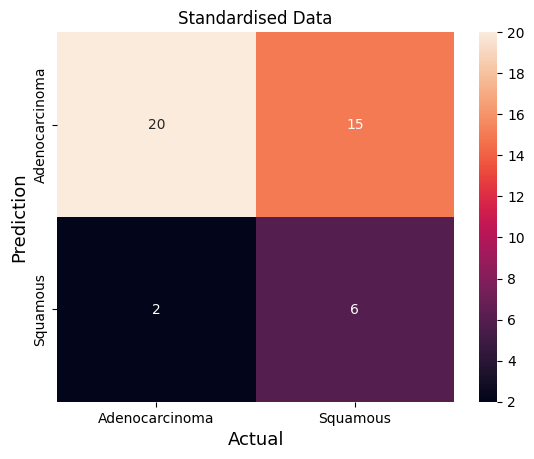

In [ ]:
dat_lr=confusion_matrix(y_pred_lda,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

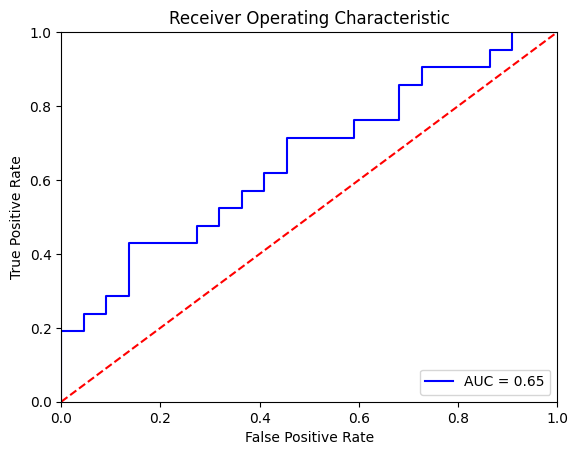

In [ ]:
probs = model_lda.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Support Vector Classifier**

In [ ]:
from sklearn.svm import SVC

model_svc = SVC(probability=True,kernel='rbf').fit(x_train,y_train)
y_pred_svc=model_svc.predict(x_test)

print("Classification Accuracy is:-",model_svc.score(x_test,y_test))

Classification Accuracy is:- 0.6511627906976745


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_svc, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.82      0.41      0.55        22
      Squamous       0.59      0.90      0.72        21

      accuracy                           0.65        43
     macro avg       0.71      0.66      0.63        43
  weighted avg       0.71      0.65      0.63        43



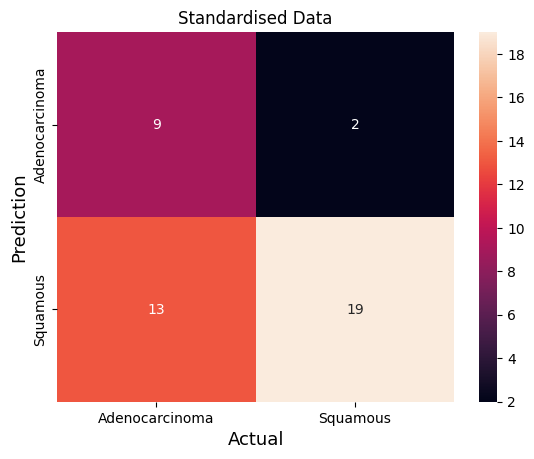

In [ ]:
dat_lr=confusion_matrix(y_pred_svc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

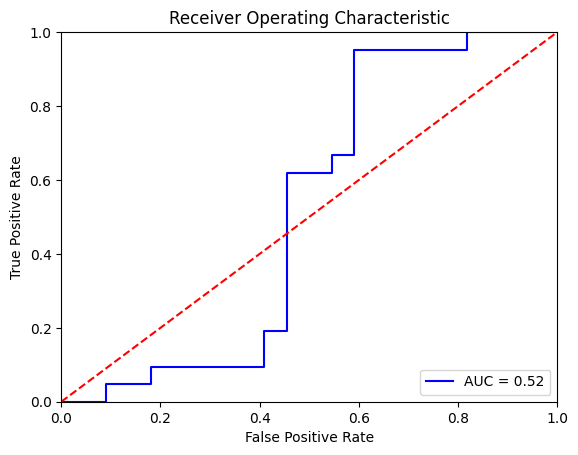

In [ ]:
probs = model_svc.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Sk-learn Neural Network Optimisation**

In [ ]:
def objective(trial):
  n_layers = trial.suggest_int("n_layers", 1, 5)

  temp_neurons=[]

  for i in range(n_layers):
    temp_neurons.append(trial.suggest_int(str(i), 1, 1000))


  model = MLPClassifier(random_state=1,hidden_layer_sizes=temp_neurons, max_iter=3000)

  #Training the Model

  model.fit(x_train,y_train.ravel())

  y_pred = model.predict(x_val)

  v0 = metrics.f1_score(y_val, y_pred, average='micro')

  return v0


study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=500)

print(study.best_params)

[I 2023-07-10 10:25:33,550] A new study created in memory with name: no-name-e6675c44-0b61-40e7-9d5f-41d673d1060a
[I 2023-07-10 10:25:37,620] Trial 0 finished with value: 0.5952380952380952 and parameters: {'n_layers': 5, '0': 884, '1': 969, '2': 634, '3': 247, '4': 681}. Best is trial 0 with value: 0.5952380952380952.
[I 2023-07-10 10:25:38,965] Trial 1 finished with value: 0.6428571428571429 and parameters: {'n_layers': 2, '0': 878, '1': 205}. Best is trial 1 with value: 0.6428571428571429.
[I 2023-07-10 10:25:39,422] Trial 2 finished with value: 0.6190476190476191 and parameters: {'n_layers': 4, '0': 3, '1': 848, '2': 202, '3': 828}. Best is trial 1 with value: 0.6428571428571429.
[I 2023-07-10 10:25:39,881] Trial 3 finished with value: 0.6666666666666666 and parameters: {'n_layers': 2, '0': 385, '1': 861}. Best is trial 3 with value: 0.6666666666666666.
[I 2023-07-10 10:25:40,736] Trial 4 finished with value: 0.7380952380952381 and parameters: {'n_layers': 5, '0': 301, '1': 195, '2

{'n_layers': 1, '0': 550}


In [ ]:
print(np.array(list(study.best_params.values()))[1:].astype(int))
temp_arrr=np.array(list(study.best_params.values()))[1:].astype(int)

In [ ]:
model_nn = MLPClassifier(random_state=1,hidden_layer_sizes=temp_arrr, max_iter=3000).fit(x_train,y_train)
y_pred_nn=model_nn.predict(x_test_1)

print("Accuracy on the training data is:-",model_nn.score(x_train,y_train))
print("Classification Accuracy is:-",model_nn.score(x_test_1,y_test_1))

Accuracy on the training data is:- 0.6597938144329897
Classification Accuracy is:- 0.6588235294117647


In [ ]:
target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test_1, y_pred_nn, target_names=target_names))

                precision    recall  f1-score   support

Adenocarcinoma       0.62      0.81      0.71        43
      Squamous       0.72      0.50      0.59        42

      accuracy                           0.66        85
     macro avg       0.67      0.66      0.65        85
  weighted avg       0.67      0.66      0.65        85



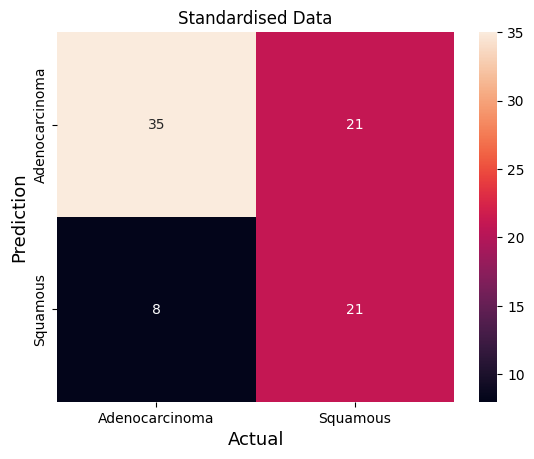

In [ ]:
dat_lr=confusion_matrix(y_pred_nn,y_test_1)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

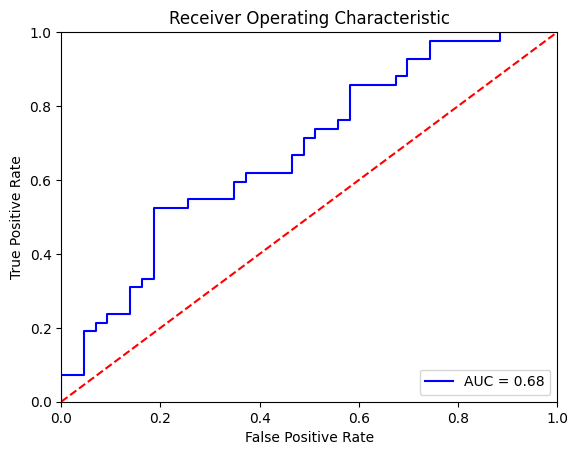

In [ ]:
probs = model_nn.predict_proba(x_test_1)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test_1, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Pytorch Neural Network Implementation**

In [ ]:
x_data=x_train
x_train_T = torch.Tensor(x_train)
y_train=y_train.reshape((-1,1))
y_train_T = torch.Tensor(y_train.astype(int))

train_data = torch.utils.data.TensorDataset(x_train_T,y_train_T)

**Validation Data**

In [ ]:
x_val_T = torch.Tensor(x_val)
y_val=y_val.reshape((-1,1))
y_val_T = torch.Tensor(y_val.astype(int))


**Testing Data**

In [ ]:
x_test_T = torch.Tensor(x_test_1)
y_test_1=y_test_1.reshape((-1,1))
y_test_T = torch.Tensor(y_test_1.astype(int))

test_data = torch.utils.data.TensorDataset(x_test_T,y_test_T)

In [ ]:
train_data_load=torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True)

**Model Building**

**Two Layers**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net2(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, size_hidden_2, n_output):
      super(Net2, self).__init__()

      self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden_1)
      self.activation_hidden_layer_1 = torch.nn.ReLU()

      self.hidden_layer_2 = torch.nn.Linear(size_hidden_1, size_hidden_2)
      self.activation_hidden_layer_2 = torch.nn.ReLU()

      self.dropout = nn.Dropout(p=0.3)

      self.output_layer = torch.nn.Linear(size_hidden_2, n_output)
      self.activation_output_layer = torch.nn.Sigmoid()


    def forward(self, x):

      temp_x1 = self.activation_hidden_layer_1(self.hidden_layer_1(x))

      temp_x2 = self.activation_hidden_layer_2(self.hidden_layer_2(temp_x1))

      temp_x3 = self.dropout(temp_x2)

      temp_x4 = self.activation_output_layer(self.output_layer(temp_x3))

      return temp_x4

**Three Layers**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net1(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, size_hidden_2,size_hidden_3 , n_output):
      super(Net1, self).__init__()

      self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden_1)
      self.activation_hidden_layer_1 = torch.nn.ReLU()

      self.hidden_layer_2 = torch.nn.Linear(size_hidden_1, size_hidden_2)
      self.activation_hidden_layer_2 = torch.nn.ReLU()

      self.hidden_layer_3 = torch.nn.Linear(size_hidden_2, size_hidden_3)
      self.activation_hidden_layer_3 = torch.nn.ReLU()

      self.dropout = nn.Dropout(p=0.3)

      self.output_layer = torch.nn.Linear(size_hidden_3, n_output)
      self.activation_output_layer = torch.nn.Sigmoid()


    def forward(self, x):

      temp_x1 = self.activation_hidden_layer_1(self.hidden_layer_1(x))

      temp_x2 = self.activation_hidden_layer_2(self.hidden_layer_2(temp_x1))

      temp_x3 = self.activation_hidden_layer_3(self.hidden_layer_3(temp_x2))

      temp_x4 = self.dropout(temp_x3)

      temp_x5 = self.activation_output_layer(self.output_layer(temp_x4))

      return temp_x5

**Four Layers**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Net3(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, size_hidden_2,size_hidden_3 ,size_hidden_4 , n_output):
      super(Net3, self).__init__()

      self.hidden_layer_1 = torch.nn.Linear(num_inputs, size_hidden_1)
      self.activation_hidden_layer_1 = torch.nn.ReLU()

      self.hidden_layer_2 = torch.nn.Linear(size_hidden_1, size_hidden_2)
      self.activation_hidden_layer_2 = torch.nn.ReLU()

      self.hidden_layer_3 = torch.nn.Linear(size_hidden_2, size_hidden_3)
      self.activation_hidden_layer_3 = torch.nn.ReLU()

      self.hidden_layer_4 = torch.nn.Linear(size_hidden_3, size_hidden_4)
      self.activation_hidden_layer_4 = torch.nn.ReLU()

      self.dropout = nn.Dropout(p=0.3)

      self.output_layer = torch.nn.Linear(size_hidden_4, n_output)
      self.activation_output_layer = torch.nn.Sigmoid()


    def forward(self, x):

      temp_x1 = self.activation_hidden_layer_1(self.hidden_layer_1(x))

      temp_x2 = self.activation_hidden_layer_2(self.hidden_layer_2(temp_x1))

      temp_x3 = self.activation_hidden_layer_3(self.hidden_layer_3(temp_x2))

      temp_x4 = self.activation_hidden_layer_4(self.hidden_layer_4(temp_x3))

      temp_x5 = self.dropout(temp_x4)

      temp_x6 = self.activation_output_layer(self.output_layer(temp_x5))

      return temp_x6

**Hyperparameter Optimisation**

In [ ]:
def objective(trial):
  x = trial.suggest_int("x", 1, 1000)
  y = trial.suggest_int("y", 1, 1000)
  z = trial.suggest_int("z", 1, 1000)

  train_data_load=torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True)

  model1 = Net1(len(x_data[0]),x,y,z,1)


  #Training the Model
  optimiser=optim.Adam(model1.parameters(),lr=0.001)

  #Loss function
  loss=torch.nn.BCELoss()

  num_epoch=100

  for i in range(num_epoch):
    losses=[]
    for batch in train_data_load:
      x,y=batch

      b=len(x)
      x=x.reshape(b,-1)

      l=model1(x)

      J=loss(l,y)

      optimiser.zero_grad()

      J.backward()

      optimiser.step()

  y_pred = model1(x_val_T)

  y_pred_np = y_pred.detach().numpy()

  y_val_np = y_val_T.numpy()

  y_temp_pred =[1 if value >= 0.5 else 0 for value in y_pred_np]

  print(y_temp_pred)

  v0 = metrics.f1_score(y_val_np, y_temp_pred, average='micro')

  return v0


study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=250)

print(study.best_params)


[I 2023-07-10 10:33:31,250] A new study created in memory with name: no-name-9bb69d89-83ac-4609-a8fd-4b2b2ee3c3f7
[I 2023-07-10 10:34:16,509] Trial 0 finished with value: 0.5 and parameters: {'x': 769, 'y': 934, 'z': 876}. Best is trial 0 with value: 0.5.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:34:37,854] Trial 1 finished with value: 0.6190476190476191 and parameters: {'x': 702, 'y': 701, 'z': 287}. Best is trial 1 with value: 0.6190476190476191.


[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:34:45,815] Trial 2 finished with value: 0.6190476190476191 and parameters: {'x': 278, 'y': 253, 'z': 559}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:34:50,112] Trial 3 finished with value: 0.5 and parameters: {'x': 631, 'y': 58, 'z': 479}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 10:35:11,158] Trial 4 finished with value: 0.47619047619047616 and parameters: {'x': 919, 'y': 514, 'z': 444}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:35:41,544] Trial 5 finished with value: 0.5476190476190477 and parameters: {'x': 881, 'y': 572, 'z': 840}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 10:36:31,424] Trial 6 finished with value: 0.5 and parameters: {'x': 928, 'y': 924, 'z': 919}. Best is trial 1 with value: 0.6190476190476191.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:36:48,115] Trial 7 finished with value: 0.5476190476190477 and parameters: {'x': 418, 'y': 780, 'z': 226}. Best is trial 1 with value: 0.6190476190476191.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 10:36:52,245] Trial 8 finished with value: 0.5952380952380952 and parameters: {'x': 204, 'y': 177, 'z': 299}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:37:08,878] Trial 9 finished with value: 0.6190476190476191 and parameters: {'x': 641, 'y': 622, 'z': 234}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:37:12,681] Trial 10 finished with value: 0.5476190476190477 and parameters: {'x': 50, 'y': 352, 'z': 106}. Best is trial 1 with value: 0.6190476190476191.


[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:37:24,231] Trial 11 finished with value: 0.5952380952380952 and parameters: {'x': 372, 'y': 330, 'z': 631}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:37:35,799] Trial 12 finished with value: 0.5714285714285714 and parameters: {'x': 265, 'y': 352, 'z': 662}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


[I 2023-07-10 10:37:48,696] Trial 13 finished with value: 0.5 and parameters: {'x': 581, 'y': 735, 'z': 14}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 10:37:53,863] Trial 14 finished with value: 0.5714285714285714 and parameters: {'x': 165, 'y': 181, 'z': 366}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]


[I 2023-07-10 10:38:22,387] Trial 15 finished with value: 0.5952380952380952 and parameters: {'x': 482, 'y': 719, 'z': 646}. Best is trial 1 with value: 0.6190476190476191.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:38:39,792] Trial 16 finished with value: 0.6428571428571429 and parameters: {'x': 793, 'y': 431, 'z': 539}. Best is trial 16 with value: 0.6428571428571429.


[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:39:03,883] Trial 17 finished with value: 0.5714285714285714 and parameters: {'x': 754, 'y': 434, 'z': 777}. Best is trial 16 with value: 0.6428571428571429.


[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 10:39:24,892] Trial 18 finished with value: 0.5714285714285714 and parameters: {'x': 768, 'y': 638, 'z': 378}. Best is trial 16 with value: 0.6428571428571429.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 10:39:50,668] Trial 19 finished with value: 0.5 and parameters: {'x': 986, 'y': 831, 'z': 131}. Best is trial 16 with value: 0.6428571428571429.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:40:11,526] Trial 20 finished with value: 0.6904761904761905 and parameters: {'x': 709, 'y': 462, 'z': 743}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]


[I 2023-07-10 10:40:33,804] Trial 21 finished with value: 0.5238095238095238 and parameters: {'x': 723, 'y': 477, 'z': 733}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:40:56,565] Trial 22 finished with value: 0.5952380952380952 and parameters: {'x': 835, 'y': 542, 'z': 548}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:41:16,400] Trial 23 finished with value: 0.47619047619047616 and parameters: {'x': 566, 'y': 421, 'z': 983}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:41:38,236] Trial 24 finished with value: 0.6190476190476191 and parameters: {'x': 665, 'y': 649, 'z': 411}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:42:17,373] Trial 25 finished with value: 0.6190476190476191 and parameters: {'x': 843, 'y': 831, 'z': 740}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:42:33,668] Trial 26 finished with value: 0.5714285714285714 and parameters: {'x': 500, 'y': 457, 'z': 573}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:42:44,119] Trial 27 finished with value: 0.5952380952380952 and parameters: {'x': 684, 'y': 269, 'z': 295}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:43:07,297] Trial 28 finished with value: 0.5 and parameters: {'x': 564, 'y': 550, 'z': 789}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:43:43,242] Trial 29 finished with value: 0.5 and parameters: {'x': 799, 'y': 956, 'z': 513}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:44:15,089] Trial 30 finished with value: 0.5 and parameters: {'x': 725, 'y': 689, 'z': 900}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:44:24,137] Trial 31 finished with value: 0.6190476190476191 and parameters: {'x': 327, 'y': 242, 'z': 598}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


[I 2023-07-10 10:44:26,704] Trial 32 finished with value: 0.5238095238095238 and parameters: {'x': 467, 'y': 14, 'z': 492}. Best is trial 20 with value: 0.6904761904761905.


[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 10:44:32,124] Trial 33 finished with value: 0.5952380952380952 and parameters: {'x': 595, 'y': 90, 'z': 697}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:44:50,125] Trial 34 finished with value: 0.6190476190476191 and parameters: {'x': 970, 'y': 386, 'z': 451}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:44:56,300] Trial 35 finished with value: 0.5476190476190477 and parameters: {'x': 90, 'y': 245, 'z': 557}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:45:15,079] Trial 36 finished with value: 0.5 and parameters: {'x': 892, 'y': 319, 'z': 845}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:45:35,296] Trial 37 finished with value: 0.6190476190476191 and parameters: {'x': 806, 'y': 507, 'z': 513}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:45:53,815] Trial 38 finished with value: 0.6190476190476191 and parameters: {'x': 696, 'y': 588, 'z': 332}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:45:58,275] Trial 39 finished with value: 0.5952380952380952 and parameters: {'x': 419, 'y': 142, 'z': 204}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:46:09,288] Trial 40 finished with value: 0.5 and parameters: {'x': 644, 'y': 281, 'z': 441}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:46:24,763] Trial 41 finished with value: 0.5714285714285714 and parameters: {'x': 624, 'y': 614, 'z': 223}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:46:47,877] Trial 42 finished with value: 0.5476190476190477 and parameters: {'x': 859, 'y': 806, 'z': 123}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 10:46:55,719] Trial 43 finished with value: 0.6190476190476191 and parameters: {'x': 292, 'y': 389, 'z': 269}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:47:14,960] Trial 44 finished with value: 0.5714285714285714 and parameters: {'x': 533, 'y': 888, 'z': 173}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:47:43,702] Trial 45 finished with value: 0.5 and parameters: {'x': 722, 'y': 696, 'z': 614}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:47:57,874] Trial 46 finished with value: 0.5 and parameters: {'x': 623, 'y': 747, 'z': 49}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:48:05,239] Trial 47 finished with value: 0.5 and parameters: {'x': 1, 'y': 531, 'z': 377}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 10:48:22,740] Trial 48 finished with value: 0.5714285714285714 and parameters: {'x': 189, 'y': 638, 'z': 660}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 10:48:36,365] Trial 49 finished with value: 0.6428571428571429 and parameters: {'x': 773, 'y': 578, 'z': 75}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:48:52,365] Trial 50 finished with value: 0.6190476190476191 and parameters: {'x': 924, 'y': 593, 'z': 33}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:49:08,162] Trial 51 finished with value: 0.6190476190476191 and parameters: {'x': 761, 'y': 497, 'z': 174}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:49:30,080] Trial 52 finished with value: 0.6428571428571429 and parameters: {'x': 790, 'y': 661, 'z': 263}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:49:53,289] Trial 53 finished with value: 0.6190476190476191 and parameters: {'x': 794, 'y': 672, 'z': 322}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:50:10,064] Trial 54 finished with value: 0.5 and parameters: {'x': 904, 'y': 576, 'z': 80}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 10:50:27,966] Trial 55 finished with value: 0.5952380952380952 and parameters: {'x': 827, 'y': 437, 'z': 416}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:50:55,125] Trial 56 finished with value: 0.6190476190476191 and parameters: {'x': 953, 'y': 779, 'z': 275}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:51:08,097] Trial 57 finished with value: 0.6190476190476191 and parameters: {'x': 747, 'y': 389, 'z': 347}. Best is trial 20 with value: 0.6904761904761905.


[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:51:24,277] Trial 58 finished with value: 0.5 and parameters: {'x': 694, 'y': 742, 'z': 4}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 10:51:39,407] Trial 59 finished with value: 0.5714285714285714 and parameters: {'x': 881, 'y': 481, 'z': 162}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:52:07,476] Trial 60 finished with value: 0.6666666666666666 and parameters: {'x': 776, 'y': 662, 'z': 692}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:52:39,714] Trial 61 finished with value: 0.6190476190476191 and parameters: {'x': 798, 'y': 683, 'z': 786}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:53:08,385] Trial 62 finished with value: 0.5 and parameters: {'x': 861, 'y': 608, 'z': 701}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:53:29,464] Trial 63 finished with value: 0.5714285714285714 and parameters: {'x': 746, 'y': 544, 'z': 531}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:53:55,937] Trial 64 finished with value: 0.6190476190476191 and parameters: {'x': 782, 'y': 657, 'z': 589}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:54:23,540] Trial 65 finished with value: 0.6190476190476191 and parameters: {'x': 664, 'y': 704, 'z': 701}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:54:34,668] Trial 66 finished with value: 0.5476190476190477 and parameters: {'x': 832, 'y': 204, 'z': 830}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:54:49,842] Trial 67 finished with value: 0.5714285714285714 and parameters: {'x': 717, 'y': 342, 'z': 739}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:55:05,900] Trial 68 finished with value: 0.5952380952380952 and parameters: {'x': 240, 'y': 558, 'z': 627}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:55:15,139] Trial 69 finished with value: 0.6428571428571429 and parameters: {'x': 102, 'y': 450, 'z': 456}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:55:29,992] Trial 70 finished with value: 0.6666666666666666 and parameters: {'x': 672, 'y': 425, 'z': 470}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:55:45,672] Trial 71 finished with value: 0.6190476190476191 and parameters: {'x': 665, 'y': 447, 'z': 475}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:56:01,012] Trial 72 finished with value: 0.5 and parameters: {'x': 602, 'y': 474, 'z': 456}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 10:56:22,814] Trial 73 finished with value: 0.5 and parameters: {'x': 765, 'y': 409, 'z': 982}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 10:56:32,745] Trial 74 finished with value: 0.6666666666666666 and parameters: {'x': 127, 'y': 516, 'z': 404}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:56:42,129] Trial 75 finished with value: 0.5238095238095238 and parameters: {'x': 131, 'y': 511, 'z': 403}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 10:56:49,867] Trial 76 finished with value: 0.6190476190476191 and parameters: {'x': 90, 'y': 360, 'z': 479}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:56:59,758] Trial 77 finished with value: 0.5 and parameters: {'x': 17, 'y': 524, 'z': 537}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 10:57:05,070] Trial 78 finished with value: 0.5952380952380952 and parameters: {'x': 59, 'y': 298, 'z': 424}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:57:15,606] Trial 79 finished with value: 0.5952380952380952 and parameters: {'x': 140, 'y': 466, 'z': 511}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:57:30,250] Trial 80 finished with value: 0.5952380952380952 and parameters: {'x': 818, 'y': 417, 'z': 249}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 10:57:51,549] Trial 81 finished with value: 0.6190476190476191 and parameters: {'x': 731, 'y': 641, 'z': 392}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 10:58:03,931] Trial 82 finished with value: 0.6190476190476191 and parameters: {'x': 683, 'y': 369, 'z': 304}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 10:58:17,686] Trial 83 finished with value: 0.5714285714285714 and parameters: {'x': 423, 'y': 558, 'z': 366}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:58:34,284] Trial 84 finished with value: 0.6190476190476191 and parameters: {'x': 777, 'y': 449, 'z': 441}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 10:58:56,412] Trial 85 finished with value: 0.6190476190476191 and parameters: {'x': 710, 'y': 496, 'z': 762}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:59:19,118] Trial 86 finished with value: 0.5 and parameters: {'x': 532, 'y': 608, 'z': 573}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:59:37,296] Trial 87 finished with value: 0.6666666666666666 and parameters: {'x': 867, 'y': 589, 'z': 200}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 10:59:54,970] Trial 88 finished with value: 0.6428571428571429 and parameters: {'x': 945, 'y': 571, 'z': 78}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:00:08,917] Trial 89 finished with value: 0.5952380952380952 and parameters: {'x': 846, 'y': 424, 'z': 142}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:00:29,392] Trial 90 finished with value: 0.5952380952380952 and parameters: {'x': 867, 'y': 589, 'z': 215}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:00:46,606] Trial 91 finished with value: 0.5 and parameters: {'x': 936, 'y': 570, 'z': 61}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:01:06,145] Trial 92 finished with value: 0.6190476190476191 and parameters: {'x': 912, 'y': 624, 'z': 128}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:01:21,890] Trial 93 finished with value: 0.6190476190476191 and parameters: {'x': 962, 'y': 514, 'z': 97}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:01:51,508] Trial 94 finished with value: 0.6190476190476191 and parameters: {'x': 744, 'y': 660, 'z': 827}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:02:05,115] Trial 95 finished with value: 0.6428571428571429 and parameters: {'x': 813, 'y': 534, 'z': 93}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:02:22,118] Trial 96 finished with value: 0.6428571428571429 and parameters: {'x': 882, 'y': 483, 'z': 189}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:02:39,600] Trial 97 finished with value: 0.5 and parameters: {'x': 781, 'y': 718, 'z': 34}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:02:53,363] Trial 98 finished with value: 0.5952380952380952 and parameters: {'x': 900, 'y': 399, 'z': 248}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:03:07,257] Trial 99 finished with value: 0.5 and parameters: {'x': 220, 'y': 459, 'z': 679}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:03:27,657] Trial 100 finished with value: 0.6428571428571429 and parameters: {'x': 983, 'y': 624, 'z': 155}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:03:41,791] Trial 101 finished with value: 0.5476190476190477 and parameters: {'x': 813, 'y': 534, 'z': 81}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 11:03:57,347] Trial 102 finished with value: 0.6190476190476191 and parameters: {'x': 801, 'y': 594, 'z': 108}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:04:11,847] Trial 103 finished with value: 0.5714285714285714 and parameters: {'x': 832, 'y': 563, 'z': 63}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 11:04:25,569] Trial 104 finished with value: 0.5952380952380952 and parameters: {'x': 858, 'y': 541, 'z': 34}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:04:49,731] Trial 105 finished with value: 0.6190476190476191 and parameters: {'x': 933, 'y': 500, 'z': 720}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:05:12,605] Trial 106 finished with value: 0.5952380952380952 and parameters: {'x': 758, 'y': 996, 'z': 92}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:05:17,588] Trial 107 finished with value: 0.5952380952380952 and parameters: {'x': 90, 'y': 435, 'z': 188}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:05:38,210] Trial 108 finished with value: 0.5238095238095238 and parameters: {'x': 789, 'y': 672, 'z': 315}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 11:05:44,984] Trial 109 finished with value: 0.6428571428571429 and parameters: {'x': 168, 'y': 375, 'z': 352}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:05:59,451] Trial 110 finished with value: 0.5 and parameters: {'x': 1000, 'y': 487, 'z': 14}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:06:15,747] Trial 111 finished with value: 0.6666666666666666 and parameters: {'x': 895, 'y': 471, 'z': 194}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:06:23,675] Trial 112 finished with value: 0.6190476190476191 and parameters: {'x': 358, 'y': 523, 'z': 114}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:06:46,070] Trial 113 finished with value: 0.6190476190476191 and parameters: {'x': 870, 'y': 576, 'z': 483}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:07:04,599] Trial 114 finished with value: 0.5 and parameters: {'x': 841, 'y': 465, 'z': 463}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:07:19,167] Trial 115 finished with value: 0.5476190476190477 and parameters: {'x': 817, 'y': 422, 'z': 282}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:07:39,583] Trial 116 finished with value: 0.6904761904761905 and parameters: {'x': 943, 'y': 633, 'z': 146}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:08:02,978] Trial 117 finished with value: 0.5476190476190477 and parameters: {'x': 951, 'y': 767, 'z': 145}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:08:23,324] Trial 118 finished with value: 0.5952380952380952 and parameters: {'x': 930, 'y': 639, 'z': 199}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:08:46,908] Trial 119 finished with value: 0.5476190476190477 and parameters: {'x': 889, 'y': 707, 'z': 249}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:09:06,386] Trial 120 finished with value: 0.6190476190476191 and parameters: {'x': 972, 'y': 610, 'z': 174}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:09:21,968] Trial 121 finished with value: 0.5476190476190477 and parameters: {'x': 905, 'y': 580, 'z': 75}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:09:37,210] Trial 122 finished with value: 0.5714285714285714 and parameters: {'x': 739, 'y': 545, 'z': 229}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:09:59,926] Trial 123 finished with value: 0.5476190476190477 and parameters: {'x': 766, 'y': 509, 'z': 761}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]


[I 2023-07-10 11:10:21,817] Trial 124 finished with value: 0.5714285714285714 and parameters: {'x': 843, 'y': 443, 'z': 801}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:10:45,813] Trial 125 finished with value: 0.5714285714285714 and parameters: {'x': 679, 'y': 681, 'z': 502}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:10:50,413] Trial 126 finished with value: 0.6428571428571429 and parameters: {'x': 118, 'y': 478, 'z': 123}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:11:08,467] Trial 127 finished with value: 0.5714285714285714 and parameters: {'x': 713, 'y': 657, 'z': 169}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:11:22,027] Trial 128 finished with value: 0.5714285714285714 and parameters: {'x': 57, 'y': 593, 'z': 651}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:11:42,493] Trial 129 finished with value: 0.5 and parameters: {'x': 650, 'y': 625, 'z': 426}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:11:58,275] Trial 130 finished with value: 0.6428571428571429 and parameters: {'x': 915, 'y': 409, 'z': 389}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:12:13,905] Trial 131 finished with value: 0.5476190476190477 and parameters: {'x': 879, 'y': 487, 'z': 194}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:12:29,643] Trial 132 finished with value: 0.5476190476190477 and parameters: {'x': 942, 'y': 458, 'z': 137}. Best is trial 20 with value: 0.6904761904761905.


[0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:12:45,236] Trial 133 finished with value: 0.6190476190476191 and parameters: {'x': 797, 'y': 530, 'z': 210}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:13:00,691] Trial 134 finished with value: 0.5 and parameters: {'x': 852, 'y': 505, 'z': 49}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:13:20,371] Trial 135 finished with value: 0.5952380952380952 and parameters: {'x': 822, 'y': 555, 'z': 187}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:13:35,006] Trial 136 finished with value: 0.6428571428571429 and parameters: {'x': 882, 'y': 477, 'z': 150}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:13:47,456] Trial 137 finished with value: 0.6190476190476191 and parameters: {'x': 455, 'y': 394, 'z': 522}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 11:13:56,549] Trial 138 finished with value: 0.5714285714285714 and parameters: {'x': 764, 'y': 330, 'z': 95}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:14:18,976] Trial 139 finished with value: 0.5 and parameters: {'x': 896, 'y': 440, 'z': 878}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:14:41,531] Trial 140 finished with value: 0.5714285714285714 and parameters: {'x': 783, 'y': 605, 'z': 553}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 11:15:00,677] Trial 141 finished with value: 0.6666666666666666 and parameters: {'x': 960, 'y': 633, 'z': 152}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:15:20,170] Trial 142 finished with value: 0.6190476190476191 and parameters: {'x': 969, 'y': 636, 'z': 109}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:15:39,027] Trial 143 finished with value: 0.6190476190476191 and parameters: {'x': 990, 'y': 569, 'z': 212}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:16:01,636] Trial 144 finished with value: 0.5952380952380952 and parameters: {'x': 922, 'y': 658, 'z': 240}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:16:19,077] Trial 145 finished with value: 0.6428571428571429 and parameters: {'x': 860, 'y': 523, 'z': 269}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:16:34,018] Trial 146 finished with value: 0.5476190476190477 and parameters: {'x': 949, 'y': 457, 'z': 158}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:16:48,307] Trial 147 finished with value: 0.6428571428571429 and parameters: {'x': 810, 'y': 548, 'z': 83}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:17:06,719] Trial 148 finished with value: 0.5952380952380952 and parameters: {'x': 912, 'y': 692, 'z': 120}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:17:25,969] Trial 149 finished with value: 0.5 and parameters: {'x': 726, 'y': 722, 'z': 180}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 11:17:49,722] Trial 150 finished with value: 0.5 and parameters: {'x': 876, 'y': 496, 'z': 722}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:18:09,114] Trial 151 finished with value: 0.5 and parameters: {'x': 994, 'y': 621, 'z': 62}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:18:28,110] Trial 152 finished with value: 0.6190476190476191 and parameters: {'x': 933, 'y': 630, 'z': 154}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:18:46,863] Trial 153 finished with value: 0.5714285714285714 and parameters: {'x': 975, 'y': 602, 'z': 129}. Best is trial 20 with value: 0.6904761904761905.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:19:17,807] Trial 154 finished with value: 0.5 and parameters: {'x': 955, 'y': 673, 'z': 678}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:19:38,139] Trial 155 finished with value: 0.6428571428571429 and parameters: {'x': 985, 'y': 577, 'z': 165}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:20:01,810] Trial 156 finished with value: 0.5 and parameters: {'x': 838, 'y': 614, 'z': 462}. Best is trial 20 with value: 0.6904761904761905.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:20:13,243] Trial 157 finished with value: 0.6190476190476191 and parameters: {'x': 309, 'y': 646, 'z': 227}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:20:29,534] Trial 158 finished with value: 0.6190476190476191 and parameters: {'x': 894, 'y': 428, 'z': 434}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:20:44,477] Trial 159 finished with value: 0.6428571428571429 and parameters: {'x': 803, 'y': 590, 'z': 102}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:20:50,022] Trial 160 finished with value: 0.5476190476190477 and parameters: {'x': 36, 'y': 535, 'z': 201}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:20:57,263] Trial 161 finished with value: 0.6190476190476191 and parameters: {'x': 156, 'y': 392, 'z': 367}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:21:04,550] Trial 162 finished with value: 0.6666666666666666 and parameters: {'x': 116, 'y': 379, 'z': 350}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:21:08,969] Trial 163 finished with value: 0.5714285714285714 and parameters: {'x': 83, 'y': 471, 'z': 137}. Best is trial 20 with value: 0.6904761904761905.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:21:16,290] Trial 164 finished with value: 0.7142857142857143 and parameters: {'x': 112, 'y': 418, 'z': 335}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:21:22,111] Trial 165 finished with value: 0.5 and parameters: {'x': 132, 'y': 352, 'z': 325}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 11:21:29,079] Trial 166 finished with value: 0.5 and parameters: {'x': 118, 'y': 373, 'z': 347}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:21:35,492] Trial 167 finished with value: 0.5714285714285714 and parameters: {'x': 71, 'y': 412, 'z': 308}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:21:42,174] Trial 168 finished with value: 0.5 and parameters: {'x': 109, 'y': 440, 'z': 339}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:21:50,112] Trial 169 finished with value: 0.6428571428571429 and parameters: {'x': 172, 'y': 406, 'z': 400}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:21:56,577] Trial 170 finished with value: 0.6428571428571429 and parameters: {'x': 28, 'y': 453, 'z': 379}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:22:05,719] Trial 171 finished with value: 0.5714285714285714 and parameters: {'x': 102, 'y': 489, 'z': 407}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 11:22:13,619] Trial 172 finished with value: 0.5952380952380952 and parameters: {'x': 153, 'y': 511, 'z': 288}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:22:20,110] Trial 173 finished with value: 0.5952380952380952 and parameters: {'x': 206, 'y': 425, 'z': 253}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 11:22:39,458] Trial 174 finished with value: 0.6190476190476191 and parameters: {'x': 698, 'y': 562, 'z': 492}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:23:06,938] Trial 175 finished with value: 0.5952380952380952 and parameters: {'x': 751, 'y': 631, 'z': 751}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]


[I 2023-07-10 11:23:28,177] Trial 176 finished with value: 0.5714285714285714 and parameters: {'x': 962, 'y': 659, 'z': 167}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:23:45,478] Trial 177 finished with value: 0.5 and parameters: {'x': 780, 'y': 460, 'z': 447}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:24:01,181] Trial 178 finished with value: 0.6428571428571429 and parameters: {'x': 619, 'y': 478, 'z': 419}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:24:09,726] Trial 179 finished with value: 0.5476190476190477 and parameters: {'x': 822, 'y': 307, 'z': 41}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]


[I 2023-07-10 11:24:19,891] Trial 180 finished with value: 0.5952380952380952 and parameters: {'x': 567, 'y': 388, 'z': 223}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:24:27,139] Trial 181 finished with value: 0.5714285714285714 and parameters: {'x': 169, 'y': 343, 'z': 331}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:24:34,313] Trial 182 finished with value: 0.5952380952380952 and parameters: {'x': 141, 'y': 377, 'z': 362}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 11:24:40,615] Trial 183 finished with value: 0.5714285714285714 and parameters: {'x': 105, 'y': 361, 'z': 300}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:24:45,095] Trial 184 finished with value: 0.5714285714285714 and parameters: {'x': 73, 'y': 424, 'z': 189}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:25:11,223] Trial 185 finished with value: 0.5 and parameters: {'x': 947, 'y': 594, 'z': 347}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:25:16,177] Trial 186 finished with value: 0.6428571428571429 and parameters: {'x': 183, 'y': 408, 'z': 70}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:25:38,392] Trial 187 finished with value: 0.6190476190476191 and parameters: {'x': 923, 'y': 437, 'z': 805}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:25:47,931] Trial 188 finished with value: 0.5952380952380952 and parameters: {'x': 132, 'y': 686, 'z': 273}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:26:07,478] Trial 189 finished with value: 0.6190476190476191 and parameters: {'x': 249, 'y': 525, 'z': 930}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:26:28,069] Trial 190 finished with value: 0.6666666666666666 and parameters: {'x': 865, 'y': 554, 'z': 391}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:26:48,476] Trial 191 finished with value: 0.6190476190476191 and parameters: {'x': 857, 'y': 561, 'z': 388}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:27:14,206] Trial 192 finished with value: 0.5952380952380952 and parameters: {'x': 899, 'y': 615, 'z': 470}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:27:33,908] Trial 193 finished with value: 0.5952380952380952 and parameters: {'x': 874, 'y': 544, 'z': 375}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0]


[I 2023-07-10 11:27:49,247] Trial 194 finished with value: 0.5714285714285714 and parameters: {'x': 793, 'y': 584, 'z': 151}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:28:07,130] Trial 195 finished with value: 0.6190476190476191 and parameters: {'x': 832, 'y': 496, 'z': 363}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:28:31,638] Trial 196 finished with value: 0.5714285714285714 and parameters: {'x': 937, 'y': 636, 'z': 419}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 11:28:57,863] Trial 197 finished with value: 0.6666666666666666 and parameters: {'x': 974, 'y': 652, 'z': 438}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:29:24,572] Trial 198 finished with value: 0.5476190476190477 and parameters: {'x': 991, 'y': 655, 'z': 445}. Best is trial 164 with value: 0.7142857142857143.


[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 11:29:52,787] Trial 199 finished with value: 0.5952380952380952 and parameters: {'x': 967, 'y': 665, 'z': 481}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0]


[I 2023-07-10 11:30:19,796] Trial 200 finished with value: 0.6428571428571429 and parameters: {'x': 977, 'y': 700, 'z': 402}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:30:43,768] Trial 201 finished with value: 0.5 and parameters: {'x': 919, 'y': 606, 'z': 425}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:30:59,443] Trial 202 finished with value: 0.5952380952380952 and parameters: {'x': 760, 'y': 645, 'z': 121}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]


[I 2023-07-10 11:31:20,156] Trial 203 finished with value: 0.5952380952380952 and parameters: {'x': 1000, 'y': 470, 'z': 458}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]


[I 2023-07-10 11:31:23,543] Trial 204 finished with value: 0.6190476190476191 and parameters: {'x': 92, 'y': 382, 'z': 87}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:31:43,993] Trial 205 finished with value: 0.6190476190476191 and parameters: {'x': 886, 'y': 566, 'z': 343}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:32:01,671] Trial 206 finished with value: 0.5238095238095238 and parameters: {'x': 942, 'y': 447, 'z': 394}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:32:19,151] Trial 207 finished with value: 0.6190476190476191 and parameters: {'x': 741, 'y': 620, 'z': 186}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:32:39,781] Trial 208 finished with value: 0.5 and parameters: {'x': 816, 'y': 515, 'z': 628}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:33:02,471] Trial 209 finished with value: 0.5 and parameters: {'x': 959, 'y': 577, 'z': 434}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:33:19,597] Trial 210 finished with value: 0.5476190476190477 and parameters: {'x': 771, 'y': 546, 'z': 210}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:33:24,535] Trial 211 finished with value: 0.6190476190476191 and parameters: {'x': 129, 'y': 481, 'z': 129}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:33:29,768] Trial 212 finished with value: 0.6190476190476191 and parameters: {'x': 109, 'y': 456, 'z': 150}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:33:33,999] Trial 213 finished with value: 0.5952380952380952 and parameters: {'x': 55, 'y': 501, 'z': 109}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]


[I 2023-07-10 11:33:54,043] Trial 214 finished with value: 0.5952380952380952 and parameters: {'x': 797, 'y': 474, 'z': 596}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:34:01,475] Trial 215 finished with value: 0.5714285714285714 and parameters: {'x': 367, 'y': 414, 'z': 138}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:34:05,922] Trial 216 finished with value: 0.5476190476190477 and parameters: {'x': 110, 'y': 440, 'z': 112}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]


[I 2023-07-10 11:34:19,290] Trial 217 finished with value: 0.5238095238095238 and parameters: {'x': 148, 'y': 597, 'z': 507}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:34:24,939] Trial 218 finished with value: 0.6666666666666666 and parameters: {'x': 125, 'y': 524, 'z': 162}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:34:45,993] Trial 219 finished with value: 0.6190476190476191 and parameters: {'x': 852, 'y': 674, 'z': 177}. Best is trial 164 with value: 0.7142857142857143.


[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:34:53,034] Trial 220 finished with value: 0.6904761904761905 and parameters: {'x': 77, 'y': 524, 'z': 361}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:00,963] Trial 221 finished with value: 0.6190476190476191 and parameters: {'x': 71, 'y': 530, 'z': 356}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:09,087] Trial 222 finished with value: 0.5714285714285714 and parameters: {'x': 89, 'y': 538, 'z': 315}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:16,764] Trial 223 finished with value: 0.6428571428571429 and parameters: {'x': 42, 'y': 510, 'z': 390}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:38,316] Trial 224 finished with value: 0.5 and parameters: {'x': 912, 'y': 558, 'z': 375}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:45,675] Trial 225 finished with value: 0.5238095238095238 and parameters: {'x': 138, 'y': 642, 'z': 166}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:35:51,177] Trial 226 finished with value: 0.6666666666666666 and parameters: {'x': 79, 'y': 523, 'z': 211}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:35:57,242] Trial 227 finished with value: 0.5476190476190477 and parameters: {'x': 83, 'y': 523, 'z': 235}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:36:08,295] Trial 228 finished with value: 0.6190476190476191 and parameters: {'x': 513, 'y': 496, 'z': 189}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:36:26,122] Trial 229 finished with value: 0.6428571428571429 and parameters: {'x': 867, 'y': 555, 'z': 201}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:36:32,465] Trial 230 finished with value: 0.6904761904761905 and parameters: {'x': 61, 'y': 579, 'z': 220}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:36:38,404] Trial 231 finished with value: 0.5476190476190477 and parameters: {'x': 53, 'y': 596, 'z': 220}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:36:43,788] Trial 232 finished with value: 0.6666666666666666 and parameters: {'x': 1, 'y': 532, 'z': 249}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


[I 2023-07-10 11:36:49,624] Trial 233 finished with value: 0.6428571428571429 and parameters: {'x': 24, 'y': 529, 'z': 251}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:36:57,016] Trial 234 finished with value: 0.6190476190476191 and parameters: {'x': 76, 'y': 546, 'z': 255}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:37:02,757] Trial 235 finished with value: 0.6666666666666666 and parameters: {'x': 25, 'y': 579, 'z': 228}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]


[I 2023-07-10 11:37:08,706] Trial 236 finished with value: 0.5238095238095238 and parameters: {'x': 21, 'y': 573, 'z': 230}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:37:14,353] Trial 237 finished with value: 0.38095238095238093 and parameters: {'x': 1, 'y': 574, 'z': 282}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[I 2023-07-10 11:37:19,582] Trial 238 finished with value: 0.5714285714285714 and parameters: {'x': 7, 'y': 546, 'z': 213}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:37:26,177] Trial 239 finished with value: 0.5714285714285714 and parameters: {'x': 66, 'y': 517, 'z': 261}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:37:31,909] Trial 240 finished with value: 0.47619047619047616 and parameters: {'x': 43, 'y': 583, 'z': 224}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


[I 2023-07-10 11:37:37,111] Trial 241 finished with value: 0.5 and parameters: {'x': 49, 'y': 505, 'z': 197}. Best is trial 164 with value: 0.7142857142857143.


[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:37:41,936] Trial 242 finished with value: 0.5714285714285714 and parameters: {'x': 39, 'y': 537, 'z': 205}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


[I 2023-07-10 11:37:47,844] Trial 243 finished with value: 0.5714285714285714 and parameters: {'x': 94, 'y': 488, 'z': 179}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]


[I 2023-07-10 11:37:58,987] Trial 244 finished with value: 0.6666666666666666 and parameters: {'x': 113, 'y': 565, 'z': 446}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:38:09,627] Trial 245 finished with value: 0.5714285714285714 and parameters: {'x': 109, 'y': 560, 'z': 459}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:38:18,136] Trial 246 finished with value: 0.5952380952380952 and parameters: {'x': 17, 'y': 582, 'z': 434}. Best is trial 164 with value: 0.7142857142857143.


[1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


[I 2023-07-10 11:38:30,338] Trial 247 finished with value: 0.6666666666666666 and parameters: {'x': 122, 'y': 618, 'z': 477}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:38:42,538] Trial 248 finished with value: 0.6666666666666666 and parameters: {'x': 124, 'y': 605, 'z': 488}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


[I 2023-07-10 11:38:54,778] Trial 249 finished with value: 0.6904761904761905 and parameters: {'x': 122, 'y': 610, 'z': 483}. Best is trial 164 with value: 0.7142857142857143.


[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1]
{'x': 112, 'y': 418, 'z': 335}


In [ ]:
temp_neuron_size = list(study.best_params.values())

model1=Net1(len(x_train[0]),temp_neuron_size[0],temp_neuron_size[1],temp_neuron_size[2],1)

print(model1)

Net1(
  (hidden_layer_1): Linear(in_features=8, out_features=112, bias=True)
  (activation_hidden_layer_1): ReLU()
  (hidden_layer_2): Linear(in_features=112, out_features=418, bias=True)
  (activation_hidden_layer_2): ReLU()
  (hidden_layer_3): Linear(in_features=418, out_features=335, bias=True)
  (activation_hidden_layer_3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=335, out_features=1, bias=True)
  (activation_output_layer): Sigmoid()
)


**Training**

Training Loss for epoch 1: 7.526028156280518
Validation Loss for epoch 1: 38.582462310791016
Training Loss for epoch 2: 4.626775741577148
Validation Loss for epoch 2: 38.859771728515625
Training Loss for epoch 3: 6.505312919616699
Validation Loss for epoch 3: 41.1853141784668
Training Loss for epoch 4: 5.0647969245910645
Validation Loss for epoch 4: 34.46403121948242
Training Loss for epoch 5: 5.677504539489746
Validation Loss for epoch 5: 40.76642608642578
Training Loss for epoch 6: 6.421786785125732
Validation Loss for epoch 6: 35.93265914916992
Training Loss for epoch 7: 5.578948497772217
Validation Loss for epoch 7: 36.608558654785156
Training Loss for epoch 8: 4.719902992248535
Validation Loss for epoch 8: 36.75128936767578
Training Loss for epoch 9: 4.71436071395874
Validation Loss for epoch 9: 39.67089080810547
Training Loss for epoch 10: 3.829986572265625
Validation Loss for epoch 10: 40.35227584838867
Training Loss for epoch 11: 7.920948505401611
Validation Loss for epoch 11: 

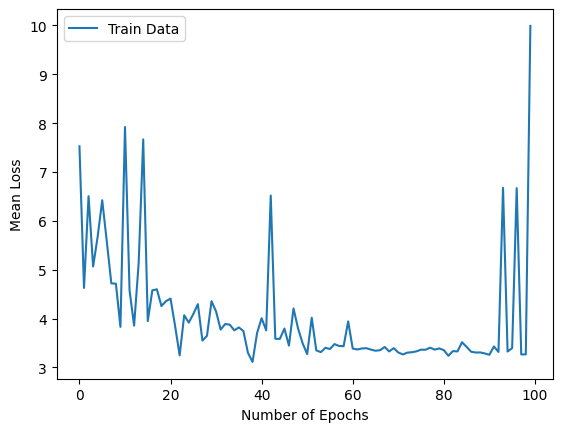

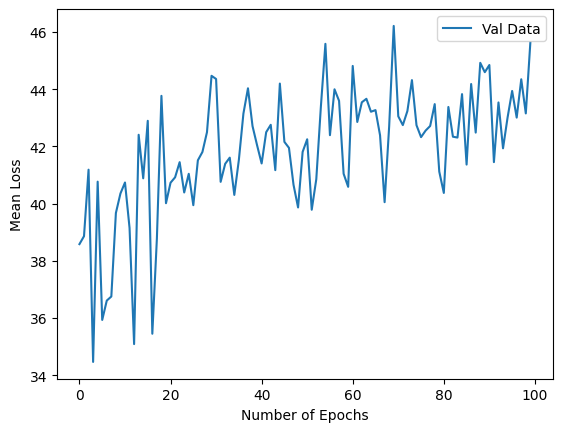

In [ ]:
#optimiser
optimiser=optim.Adam(model1.parameters(),lr=0.0005)
# optimiser=optim.SGD(model.parameters(),lr=0.0005,momentum=0.5)

#Loss function
loss=torch.nn.BCELoss()

# loss=torch.nn.L1Loss()

num_epoch=100
loss_epoch_train=[]

loss_epoch_val=[]

for i in range(num_epoch):
  losses=[]
  for batch in train_data_load:
    x,y=batch

    b=len(x)
    x=x.reshape(b,-1)

    l=model1(x)

    J=loss(l,y)

    optimiser.zero_grad()

    J.backward()

    optimiser.step()

    losses.append(J.item())

  y_pred_T=model1(x_val_T)

  J1=loss(y_val_T,y_pred_T)
  loss_epoch_val.append(J1.item())

  print("Training Loss for epoch "+str(i+1)+":",torch.tensor(losses).mean().item())
  print("Validation Loss for epoch "+str(i+1)+":",J1.item())
  loss_epoch_train.append(torch.tensor(losses).mean().item())


plt.plot(loss_epoch_train,label="Train Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

plt.plot(loss_epoch_val,label="Val Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

In [ ]:
y_pred=model1(x_test_T)
J=loss(y_pred.reshape(1,-1),y_test_T.reshape(1,-1))

print(J.item())

print(y_pred)

y_pred=y_pred.detach().numpy()
y_pred_temp=[]

for i in range(len(y_pred)):
  if (y_pred[i]>=0.5):
    y_pred_temp.append(1)
  else:
    y_pred_temp.append(0)

3.169189929962158
tensor([[3.0446e-01],
        [2.5137e-01],
        [1.9486e-01],
        [1.5153e-04],
        [5.1572e-01],
        [0.0000e+00],
        [2.9039e-01],
        [0.0000e+00],
        [4.4637e-02],
        [2.1540e-01],
        [7.1994e-01],
        [7.4036e-01],
        [4.0483e-02],
        [9.8163e-01],
        [1.4556e-01],
        [1.5008e-29],
        [0.0000e+00],
        [4.7772e-01],
        [7.8768e-01],
        [0.0000e+00],
        [6.5730e-01],
        [0.0000e+00],
        [9.0090e-01],
        [4.0283e-01],
        [5.0805e-01],
        [2.2971e-01],
        [5.8125e-01],
        [3.5890e-01],
        [3.6716e-01],
        [3.8166e-01],
        [8.8756e-01],
        [0.0000e+00],
        [8.2736e-01],
        [0.0000e+00],
        [8.9903e-02],
        [0.0000e+00],
        [7.7964e-38],
        [6.1597e-01],
        [5.8970e-01],
        [6.8712e-01],
        [4.7191e-06],
        [3.2451e-01],
        [4.6407e-01],
        [6.2258e-01],
        [3.786

In [ ]:
y_test_temp=y_test_T.detach().numpy().astype(int)

target_names = ['class 0', 'class 1']

print(classification_report(y_test_temp, y_pred_temp, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.53      0.67      0.59        43
     class 1       0.53      0.38      0.44        42

    accuracy                           0.53        85
   macro avg       0.53      0.53      0.52        85
weighted avg       0.53      0.53      0.52        85



In [ ]:
print(list(y_test_temp.ravel()))
print(y_pred_temp)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0]


In [ ]:
class_0=[]
class_1=[]
y_pred=y_pred.ravel()
for i in range(len(y_pred_temp)):
  if (y_test_temp[i]==0):
    class_0.append(y_pred[i])
  else:
    class_1.append(y_pred[i])

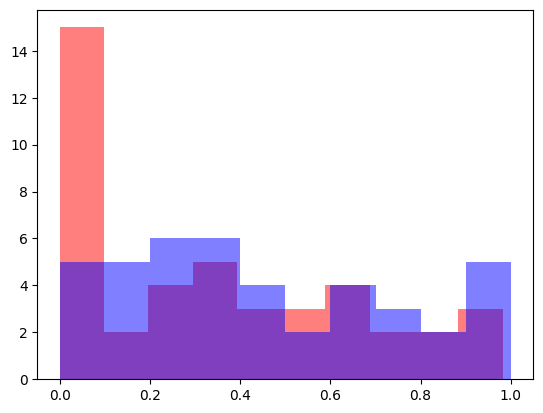

In [ ]:
plt.hist(class_0,color="red",alpha=0.5)
plt.hist(class_1,color="blue",alpha=0.5)

plt.show()


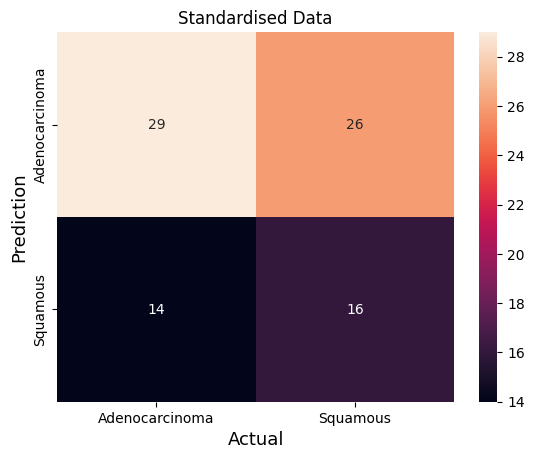

In [ ]:
dat_lr=confusion_matrix(y_pred_temp,y_test_temp)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==0 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

SRR3991359
SRR3991510
SRR3991593
SRR3991362
SRR3991474
SRR3991437
SRR3991455
SRR3991346
SRR3991615
SRR3991612
SRR3991453
SRR3991481
SRR3991371
SRR3991490
SRR3991355
SRR3991426
SRR3991461
SRR3991338
SRR3991364
SRR3991357
SRR3991404
SRR3991581
SRR3991570
SRR3991448
SRR3991415
SRR3991552


In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==1 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

SRR3991560
SRR3991555
SRR3991527
SRR3991496
SRR3991559
SRR3991513
SRR3991395
SRR3991541
SRR3991353
SRR3991548
SRR3991394
SRR3991603
SRR3991348
SRR3991421


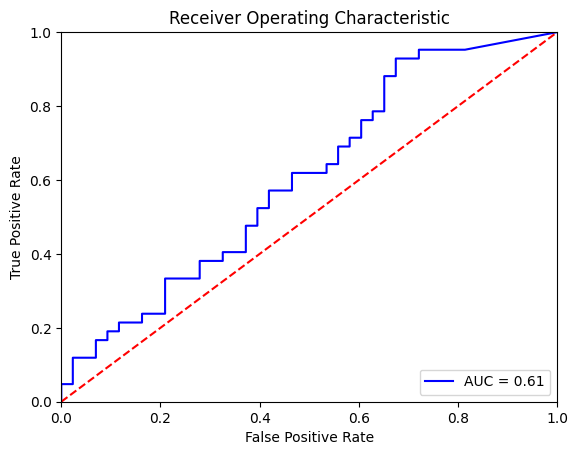

In [ ]:
preds = y_pred

fpr, tpr, threshold = metrics.roc_curve(y_test_temp, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def objective(trial):
  x = trial.suggest_int("x", 1, 1000)
  y = trial.suggest_int("y", 1, 1000)

  train_data_load=torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True)

  model2 = Net2(len(x_data[0]),x,y,1)


  #Training the Model

  optimiser=optim.Adam(model2.parameters(),lr=0.001)

  #Loss function
  loss=torch.nn.BCELoss()

  num_epoch=100

  for i in range(num_epoch):
    losses=[]
    for batch in train_data_load:
      x,y=batch

      b=len(x)
      x=x.reshape(b,-1)

      l=model2(x)

      J=loss(l,y)

      optimiser.zero_grad()

      J.backward()

      optimiser.step()


  y_pred = model2(x_val_T)

  y_pred_np = y_pred.detach().numpy()

  y_val_np = y_val_T.numpy()

  y_temp_pred = y_pred_np>0.5

  v0 = metrics.f1_score(y_val_np, y_temp_pred, average='micro')

  return v0


study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=200)

print(study.best_params)


[I 2023-07-10 11:39:03,465] A new study created in memory with name: no-name-7d54cd5b-c8b1-4c2b-9d7a-f2ea3dae03e0
[I 2023-07-10 11:39:19,128] Trial 0 finished with value: 0.5 and parameters: {'x': 698, 'y': 787}. Best is trial 0 with value: 0.5.
[I 2023-07-10 11:39:29,626] Trial 1 finished with value: 0.5 and parameters: {'x': 887, 'y': 350}. Best is trial 0 with value: 0.5.
[I 2023-07-10 11:39:36,290] Trial 2 finished with value: 0.6190476190476191 and parameters: {'x': 782, 'y': 236}. Best is trial 2 with value: 0.6190476190476191.
[I 2023-07-10 11:39:44,951] Trial 3 finished with value: 0.6190476190476191 and parameters: {'x': 350, 'y': 907}. Best is trial 2 with value: 0.6190476190476191.
[I 2023-07-10 11:39:48,250] Trial 4 finished with value: 0.5952380952380952 and parameters: {'x': 85, 'y': 787}. Best is trial 2 with value: 0.6190476190476191.
[I 2023-07-10 11:39:52,053] Trial 5 finished with value: 0.5 and parameters: {'x': 182, 'y': 553}. Best is trial 2 with value: 0.61904761

{'x': 253, 'y': 604}


In [ ]:
temp_neuron_size = list(study.best_params.values())

model2=Net2(len(x_train[0]),temp_neuron_size[0],temp_neuron_size[1],1)

print(model2)

Net2(
  (hidden_layer_1): Linear(in_features=8, out_features=253, bias=True)
  (activation_hidden_layer_1): ReLU()
  (hidden_layer_2): Linear(in_features=253, out_features=604, bias=True)
  (activation_hidden_layer_2): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=604, out_features=1, bias=True)
  (activation_output_layer): Sigmoid()
)


**Training**

Training Loss for epoch 1: 12.25089168548584
Validation Loss for epoch 1: 45.57670593261719
Training Loss for epoch 2: 17.566730499267578
Validation Loss for epoch 2: 45.541690826416016
Training Loss for epoch 3: 15.01270580291748
Validation Loss for epoch 3: 39.68049240112305
Training Loss for epoch 4: 15.55123233795166
Validation Loss for epoch 4: 29.921674728393555
Training Loss for epoch 5: 8.446741104125977
Validation Loss for epoch 5: 44.450653076171875
Training Loss for epoch 6: 7.864978313446045
Validation Loss for epoch 6: 43.81551742553711
Training Loss for epoch 7: 9.350137710571289
Validation Loss for epoch 7: 36.2116584777832
Training Loss for epoch 8: 13.095365524291992
Validation Loss for epoch 8: 45.40309524536133
Training Loss for epoch 9: 14.409746170043945
Validation Loss for epoch 9: 29.73615074157715
Training Loss for epoch 10: 8.140219688415527
Validation Loss for epoch 10: 33.986148834228516
Training Loss for epoch 11: 9.284795761108398
Validation Loss for epoch 

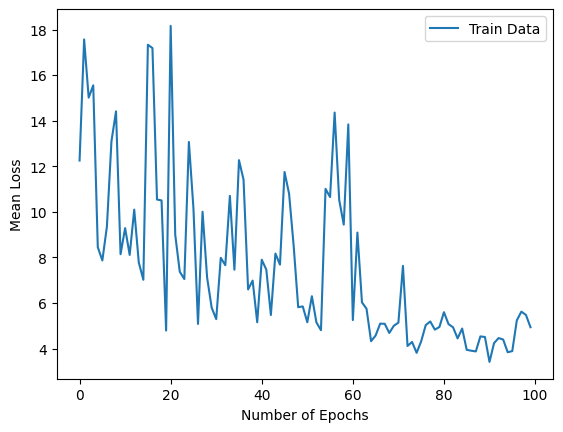

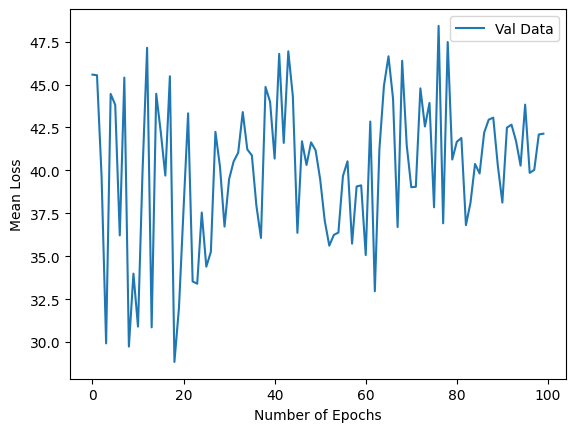

In [ ]:
#optimiser
optimiser=optim.Adam(model2.parameters(),lr=0.0005)
# optimiser=optim.SGD(model.parameters(),lr=0.0005,momentum=0.5)

#Loss function
loss=torch.nn.BCELoss()

num_epoch=100
loss_epoch_train=[]

loss_epoch_val=[]

for i in range(num_epoch):
  losses=[]
  for batch in train_data_load:
    x,y=batch

    b=len(x)
    x=x.reshape(b,-1)

    l=model2(x)

    J=loss(l,y)

    optimiser.zero_grad()

    J.backward()

    optimiser.step()

    losses.append(J.item())

  y_pred_T=model2(x_val_T)

  J1=loss(y_val_T,y_pred_T)
  loss_epoch_val.append(J1.item())

  print("Training Loss for epoch "+str(i+1)+":",torch.tensor(losses).mean().item())
  print("Validation Loss for epoch "+str(i+1)+":",J1.item())
  loss_epoch_train.append(torch.tensor(losses).mean().item())


plt.plot(loss_epoch_train,label="Train Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

plt.plot(loss_epoch_val,label="Val Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

In [ ]:
y_pred=model2(x_test_T)
J=loss(y_pred.reshape(1,-1),y_test_T.reshape(1,-1))

print(J.item())

print(y_pred)

y_pred=y_pred.detach().numpy()
y_pred_temp=[]

for i in range(len(y_pred)):
  if (y_pred[i]>0.4):
    y_pred_temp.append(1)
  else:
    y_pred_temp.append(0)

5.362199783325195
tensor([[4.2702e-01],
        [3.5714e-01],
        [1.0085e-01],
        [0.0000e+00],
        [5.0411e-01],
        [0.0000e+00],
        [7.9843e-05],
        [0.0000e+00],
        [9.9948e-01],
        [1.3583e-02],
        [4.6578e-01],
        [6.1260e-01],
        [1.0000e+00],
        [8.5270e-01],
        [5.7598e-02],
        [9.0552e-37],
        [0.0000e+00],
        [4.4730e-01],
        [6.5546e-01],
        [3.5861e-28],
        [2.7328e-02],
        [0.0000e+00],
        [1.0000e+00],
        [5.6115e-01],
        [6.8999e-01],
        [2.9170e-01],
        [6.6697e-01],
        [2.0178e-01],
        [8.5693e-01],
        [2.2588e-01],
        [7.3996e-01],
        [0.0000e+00],
        [5.3315e-01],
        [6.9076e-38],
        [7.6024e-02],
        [0.0000e+00],
        [0.0000e+00],
        [6.0056e-01],
        [5.7784e-01],
        [7.8856e-01],
        [6.6035e-04],
        [2.5057e-01],
        [5.2311e-01],
        [6.0588e-01],
        [1.327

In [ ]:
y_test_temp=y_test_T.detach().numpy().astype(int)

target_names = ['class 0', 'class 1']
print(classification_report(y_test_temp, y_pred_temp, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.53      0.53      0.53        43
     class 1       0.52      0.52      0.52        42

    accuracy                           0.53        85
   macro avg       0.53      0.53      0.53        85
weighted avg       0.53      0.53      0.53        85



In [ ]:
print(list(y_test_temp.ravel()))
print(y_pred_temp)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]


In [ ]:
class_0=[]
class_1=[]
y_pred=y_pred.ravel()
for i in range(len(y_pred_temp)):
  if (y_test_temp[i]==0):
    class_0.append(y_pred[i])
  else:
    class_1.append(y_pred[i])

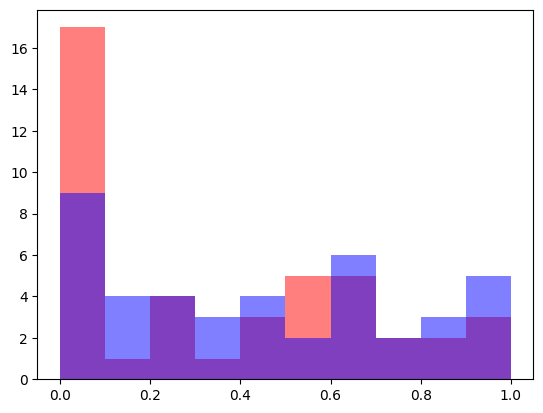

In [ ]:
plt.hist(class_0,color="red",alpha=0.5)
plt.hist(class_1,color="blue",alpha=0.5)

plt.show()


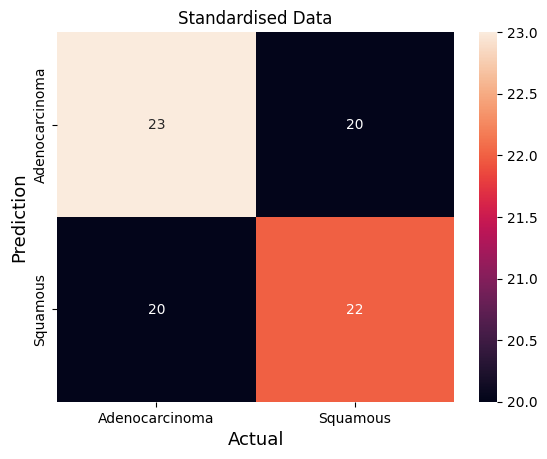

In [ ]:
dat_lr=confusion_matrix(y_pred_temp,y_test_temp)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==0 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

SRR3991359
SRR3991593
SRR3991362
SRR3991474
SRR3991455
SRR3991346
SRR3991615
SRR3991360
SRR3991612
SRR3991453
SRR3991481
SRR3991371
SRR3991490
SRR3991508
SRR3991461
SRR3991338
SRR3991364
SRR3991404
SRR3991417
SRR3991552


In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==1 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

SRR3991515
SRR3991560
SRR3991374
SRR3991555
SRR3991527
SRR3991405
SRR3991496
SRR3991392
SRR3991559
SRR3991395
SRR3991626
SRR3991541
SRR3991353
SRR3991588
SRR3991548
SRR3991394
SRR3991603
SRR3991348
SRR3991421
SRR3991609


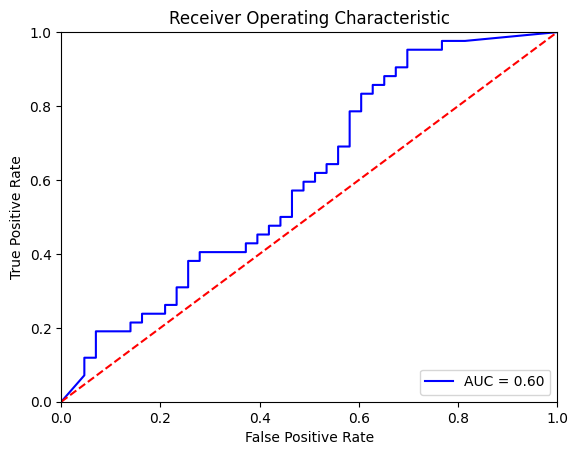

In [ ]:
preds = y_pred

fpr, tpr, threshold = metrics.roc_curve(y_test_temp, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def objective(trial):
  x = trial.suggest_int("x", 1, 1000)
  y = trial.suggest_int("y", 1, 1000)
  z = trial.suggest_int("z", 1, 1000)
  a = trial.suggest_int("a", 1, 1000)

  train_data_load=torch.utils.data.DataLoader(train_data,batch_size=16,shuffle=True)

  model3 = Net3(len(x_data[0]),x,y,z,a,1)


  #Training the Model
  optimiser=optim.Adam(model3.parameters(),lr=0.001)

  #Loss function
  loss=torch.nn.BCELoss()

  num_epoch=100

  for i in range(num_epoch):
    losses=[]
    for batch in train_data_load:
      x,y=batch

      b=len(x)
      x=x.reshape(b,-1)

      l=model3(x)

      J=loss(l,y)

      optimiser.zero_grad()

      J.backward()

      optimiser.step()

  y_pred = model3(x_val_T)

  y_pred_np = y_pred.detach().numpy()

  y_val_np = y_val_T.numpy()

  y_temp_pred =[1 if value >= 0.5 else 0 for value in y_pred_np]

  print(y_temp_pred)

  v0 = metrics.f1_score(y_val_np, y_temp_pred, average='micro')

  return v0


study = optuna.create_study(directions=["maximize"])
study.optimize(objective, n_trials=250)

print(study.best_params)


In [ ]:
temp_neuron_size = list(study.best_params.values())

model1=Net3(len(x_train[0]),temp_neuron_size[0],temp_neuron_size[1],temp_neuron_size[2],temp_neuron_size[3],1)

print(model1)

**Training**

In [ ]:
#optimiser
optimiser=optim.Adam(model1.parameters(),lr=0.0005)
# optimiser=optim.SGD(model.parameters(),lr=0.0005,momentum=0.5)

#Loss function
loss=torch.nn.BCELoss()

num_epoch=100
loss_epoch_train=[]

loss_epoch_val=[]

for i in range(num_epoch):
  losses=[]
  for batch in train_data_load:
    x,y=batch

    b=len(x)
    x=x.reshape(b,-1)

    l=model1(x)

    J=loss(l,y)

    optimiser.zero_grad()

    J.backward()

    optimiser.step()

    losses.append(J.item())

  y_pred_T=model1(x_val_T)

  J1=loss(y_pred_T,y_val_T)
  loss_epoch_val.append(J1.item())

  print("Training Loss for epoch "+str(i+1)+":",torch.tensor(losses).mean().item())
  print("Validation Loss for epoch "+str(i+1)+":",J1.item())
  loss_epoch_train.append(torch.tensor(losses).mean().item())


plt.plot(loss_epoch_train,label="Train Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

plt.plot(loss_epoch_val,label="Val Data")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Loss")
plt.show()

In [ ]:
y_pred=model1(x_test_T)
J=loss(y_pred.reshape(1,-1),y_test_T.reshape(1,-1))

print(J.item())

print(y_pred)

y_pred=y_pred.detach().numpy()
y_pred_temp=[]

for i in range(len(y_pred)):
  if (y_pred[i]>=0.5):
    y_pred_temp.append(1)
  else:
    y_pred_temp.append(0)

In [ ]:
y_test_temp=y_test_T.detach().numpy().astype(int)

target_names = ['class 0', 'class 1']

print(classification_report(y_test_temp, y_pred_temp, target_names=target_names))

In [ ]:
print(list(y_test_temp.ravel()))
print(y_pred_temp)

In [ ]:
class_0=[]
class_1=[]
y_pred=y_pred.ravel()
for i in range(len(y_pred_temp)):
  if (y_test_temp[i]==0):
    class_0.append(y_pred[i])
  else:
    class_1.append(y_pred[i])

In [ ]:
plt.hist(class_0,color="red",alpha=0.5)
plt.hist(class_1,color="blue",alpha=0.5)

plt.show()


In [ ]:
dat_lr=confusion_matrix(y_pred_temp,y_test_temp)
sns.heatmap(dat_lr,annot=True,xticklabels=['Adenocarcinoma','Squamous'],
            yticklabels=['Adenocarcinoma','Squamous'])
plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()

In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==0 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

In [ ]:
for i in range(len(y_pred_temp)):
  if (y_pred_temp[i]==1 and y_pred_temp[i]!=y_test_temp[i]):
    print(sample_id_test_1[i])

In [ ]:
preds = y_pred

fpr, tpr, threshold = metrics.roc_curve(y_test_temp, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Using Basinhoppin**

In [ ]:
def scoring_fun(x):
  print(x)
  model = Net1(len(x_train[0]),int(x[0]*1000),int(x[1]*1000),int(x[2]*1000),1)
  optimiser=optim.Adam(model1.parameters(),lr=0.001)

  #Loss function
  loss=torch.nn.BCELoss()

  num_epoch=50

  for i in range(num_epoch):
    losses=[]
    for batch in train_data_load:
      x,y=batch

      b=len(x)
      x=x.reshape(b,-1)

      l=model1(x)

      J=loss(l,y)

      optimiser.zero_grad()

      J.backward()

      optimiser.step()

  y_pred = model1(x_val_T)

  y_pred_np = y_pred.detach().numpy()

  y_val_np = y_val_T.numpy()

  y_temp_pred =[1 if value >= 0.5 else 0 for value in y_pred_np]

  print(y_temp_pred)

  v0 = metrics.f1_score(y_val_np, y_temp_pred, average='micro')

  return -1*v0

